# estimate surface melt at lon/lat points on a glacier using a PDD model

### Requirements:
### - folder containing temperature time-series at each point
### - folder containing classification time-series at each point
### degree day factor [(𝑚𝑚 𝑤.𝑒.)/℃] for ice and snow

## import libraries

In [15]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import glob

## modify inputs

In [16]:
#inputs - WOLVERINE

#path to downscaled temperatures
#files must be named corrected_temperatures_pt*.csv
temp_path = '/Users/lindsaysummers/Documents/Research/Melt_Estimates/Wolverine/15_points/' 

#path to classification time series
#files must be named pt*_classified.csv
classification_path = '/Users/lindsaysummers/Documents/Research/Snow_Cover/outputs/extracted/Wolverine/'

#degree day factor for ice [(𝑚𝑚 𝑤.𝑒.)/℃]
ddf_ice = 4.7

#degree day factor for snow [(𝑚𝑚 𝑤.𝑒.)/℃]
ddf_snow = 3.8

#path to store outputs
out_path = '/Users/lindsaysummers/Documents/Research/Melt_Estimates/Wolverine/15_points/'

In [2]:
#inputs - GULKANA

#path to downscaled temperatures
#files must be named corrected_temperatures_pt*.csv
temp_path = '/Users/lindsaysummers/Documents/Research/Melt_Estimates/Gulkana/15_points/' 

#path to classification time series
#files must be named pt*_classified.csv
classification_path = '/Users/lindsaysummers/Documents/Research/Snow_Cover/outputs/extracted/Gulkana/'

#degree day factor for ice [(𝑚𝑚 𝑤.𝑒.)/℃]
#float (not an integer)
ddf_ice = 6.0

#degree day factor for snow [(𝑚𝑚 𝑤.𝑒.)/℃]
#float (not an integer)
ddf_snow = 2.5

#path to store outputs
out_path = '/Users/lindsaysummers/Documents/Research/Melt_Estimates/Gulkana/15_points/'

## import downscaled temperatures

In [17]:
temperature_files = glob.glob(os.path.join(temp_path, 'corrected_temperatures_pt*.csv'))

#dictionary to store data
temperature_data = {}

#loop through temperature files and load them
for file_path in temperature_files:
    #extract point name from filename
    file_name = os.path.basename(file_path)
    pt_name = file_name.replace('corrected_temperatures_', '').replace('.csv', '')

    #import and clean file
    df = pd.read_csv(file_path)
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    #rename second column to "temperature" for simplicity
    second_col_name = df.columns[1]  #current name of the second column
    df.rename(columns={second_col_name: 'temperature'}, inplace=True)

    #make sure time column is datetime format
    df['time'] = pd.to_datetime(df['time'])
    
    temperature_data[pt_name] = df
    print(f'{pt_name} temperatures imported')

pt13 temperatures imported
pt9 temperatures imported
pt8 temperatures imported
pt12 temperatures imported
pt10 temperatures imported
pt11 temperatures imported
pt15 temperatures imported
pt14 temperatures imported
pt1 temperatures imported
pt3 temperatures imported
pt2 temperatures imported
pt6 temperatures imported
pt7 temperatures imported
pt5 temperatures imported
pt4 temperatures imported


## import snow vs. ice classification time series

In [18]:
#find all matching files
classification_files = glob.glob(os.path.join(classification_path, 'pt*_classified.csv'))

#dictionary to store classification data
classification_data = {}

#loop through files and load them
for file_path in classification_files:
    # Extract point name from filename
    file_name = os.path.basename(file_path)
    pt_name = file_name.replace('_classified.csv', '')

    #import and clean file
    df = pd.read_csv(file_path)
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    #rename second column to "class" for simplicity
    second_col_name = df.columns[1]  #current name of the second column
    df.rename(columns={second_col_name: 'class'}, inplace=True)

    #make sure time column is in datetime format
    df['time'] = pd.to_datetime(df['time'])

    classification_data[pt_name] = df
    print(f'{pt_name} classification values imported')

pt6 classification values imported
pt1 classification values imported
pt9 classification values imported
pt8 classification values imported
pt7 classification values imported
pt5 classification values imported
pt2 classification values imported
pt3 classification values imported
pt4 classification values imported
pt11 classification values imported
pt10 classification values imported
pt12 classification values imported
pt15 classification values imported
pt14 classification values imported
pt13 classification values imported


## combine classification and temperature data

In [19]:
temperature_and_class = {}  # dictionary to store merged DataFrames

for pt_name in temperature_data:
    if pt_name in classification_data: #make sure both classification and temp data exist for the point
        temp_df = temperature_data[pt_name].copy()
        class_df = classification_data[pt_name].copy()

        #sort by time
        temp_df = temp_df.sort_values('time')
        class_df = class_df.sort_values('time')

        #merge based on nearest time
        merged = pd.merge_asof(temp_df, class_df, on='time', direction='nearest')

        temperature_and_class[pt_name] = merged
        print(f'temperature and class combined for {pt_name}')

temperature and class combined for pt13
temperature and class combined for pt9
temperature and class combined for pt8
temperature and class combined for pt12
temperature and class combined for pt10
temperature and class combined for pt11
temperature and class combined for pt15
temperature and class combined for pt14
temperature and class combined for pt1
temperature and class combined for pt3
temperature and class combined for pt2
temperature and class combined for pt6
temperature and class combined for pt7
temperature and class combined for pt5
temperature and class combined for pt4


## interpolate snow and ice classification (fill nans based on previous value)

In [20]:
#interpolate
for pt in temperature_and_class:
    df = temperature_and_class[pt].copy()
    df['class'] = df['class'].ffill()
#    print(df['class'].value_counts(dropna=False))

## plot class for each point

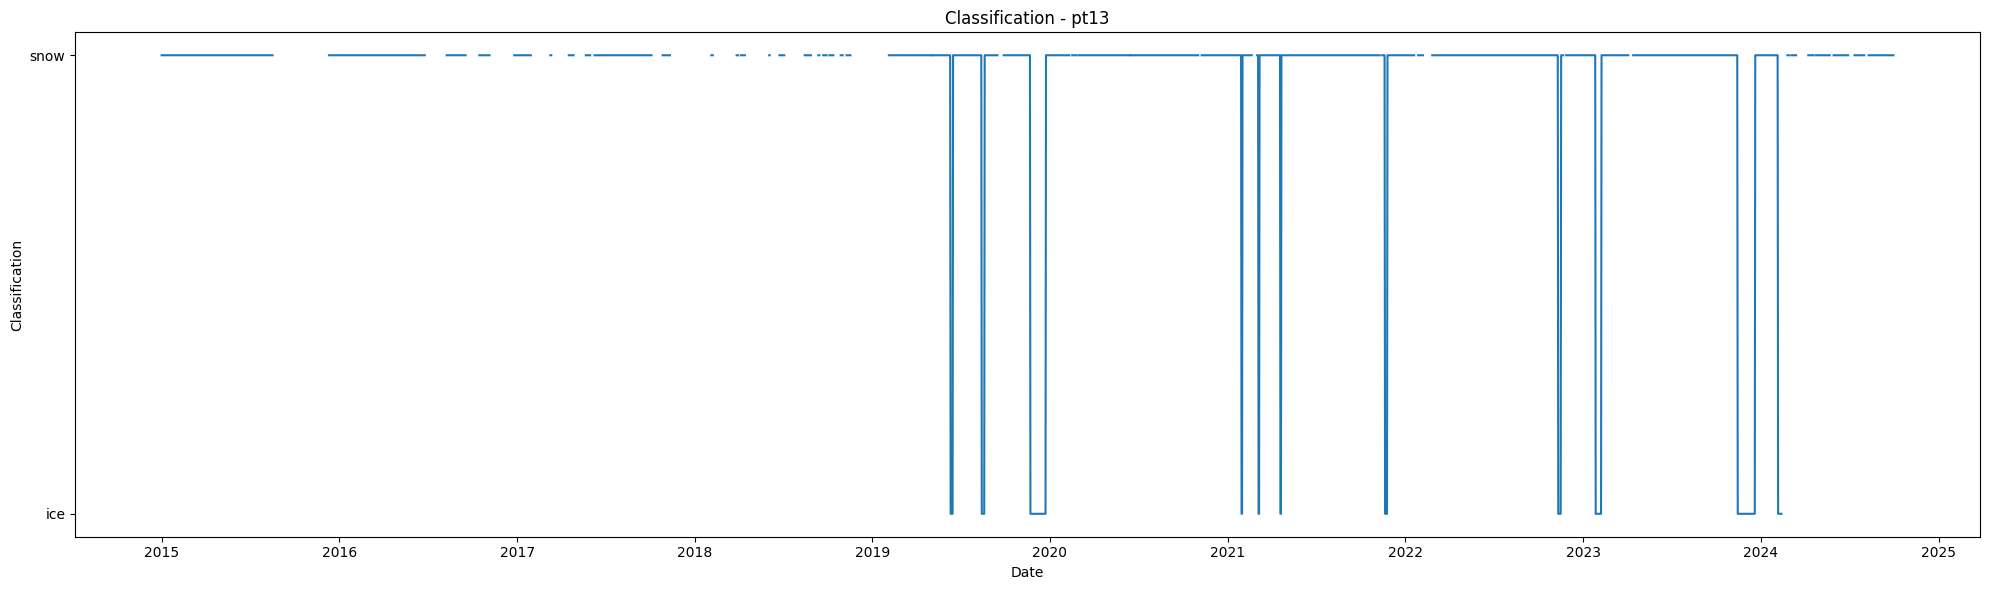

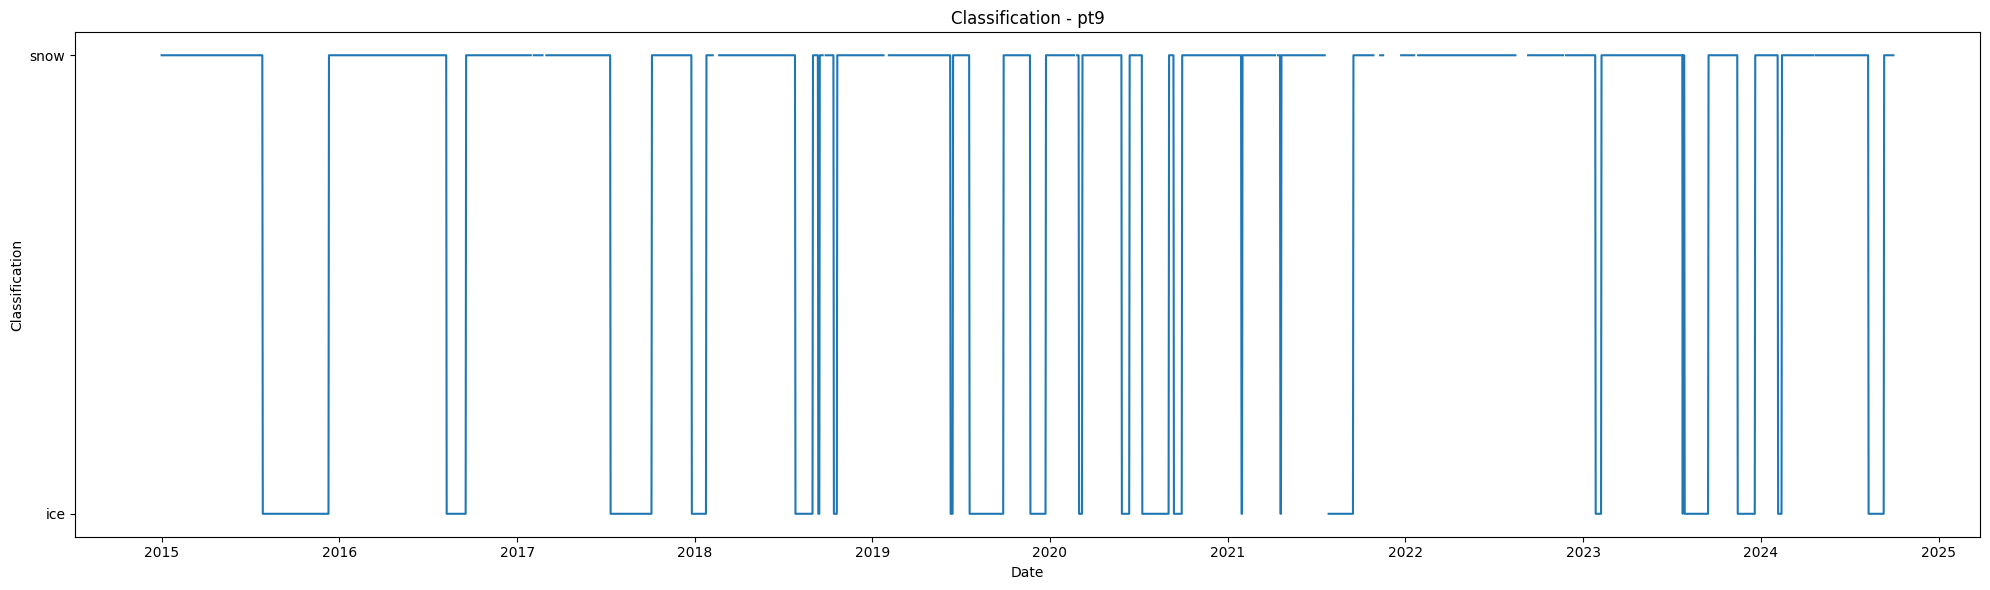

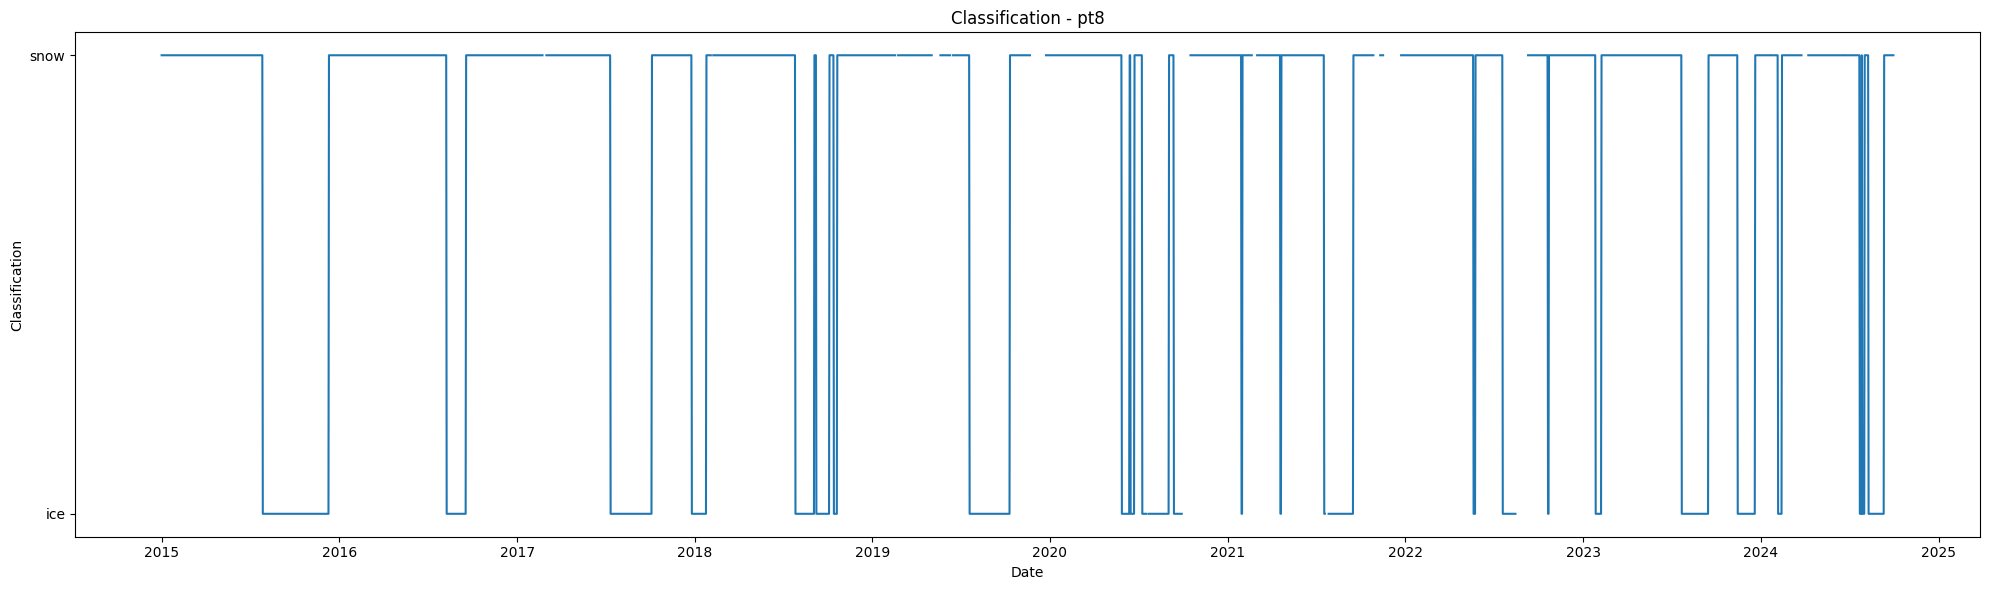

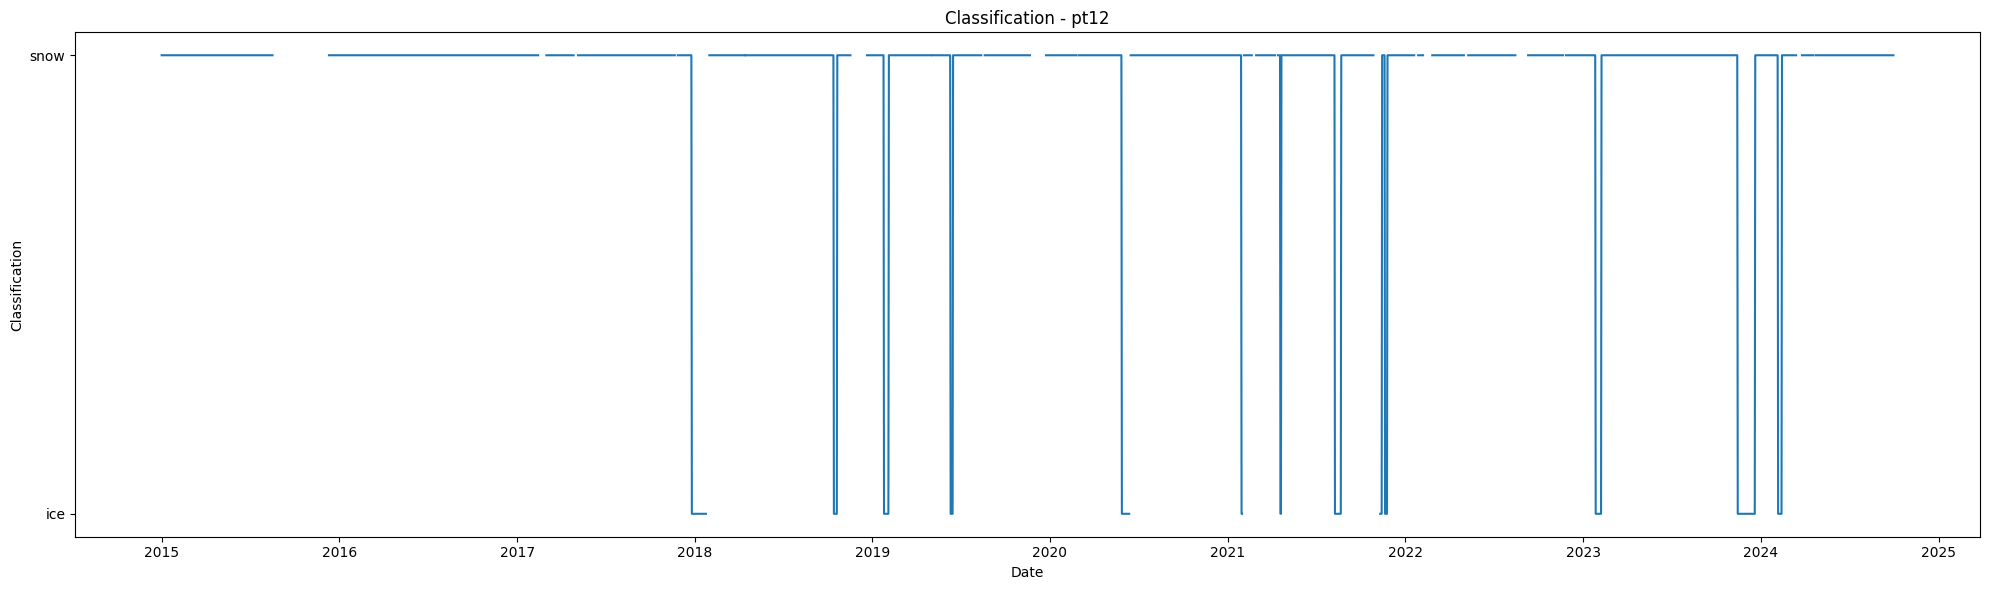

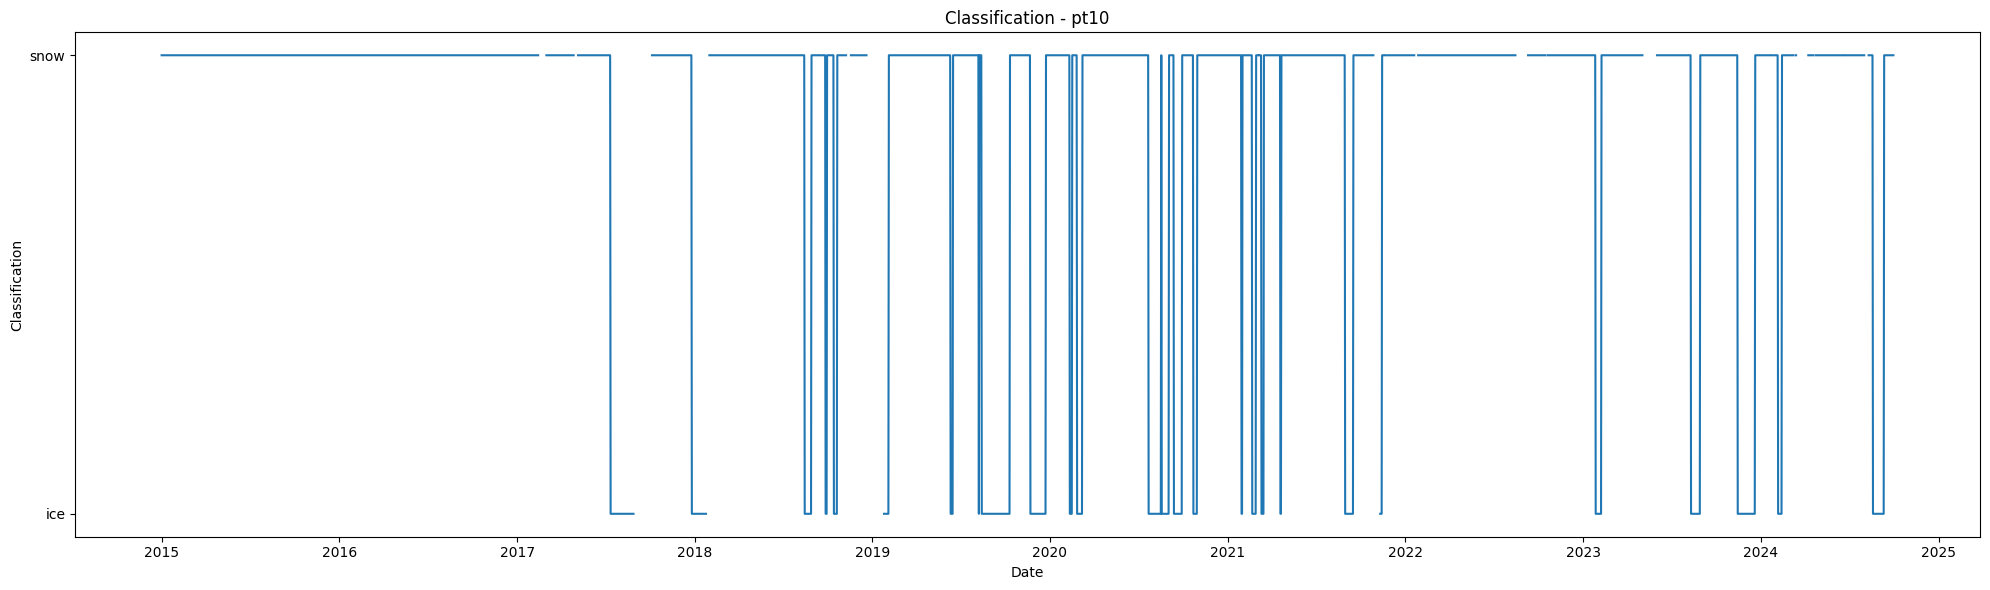

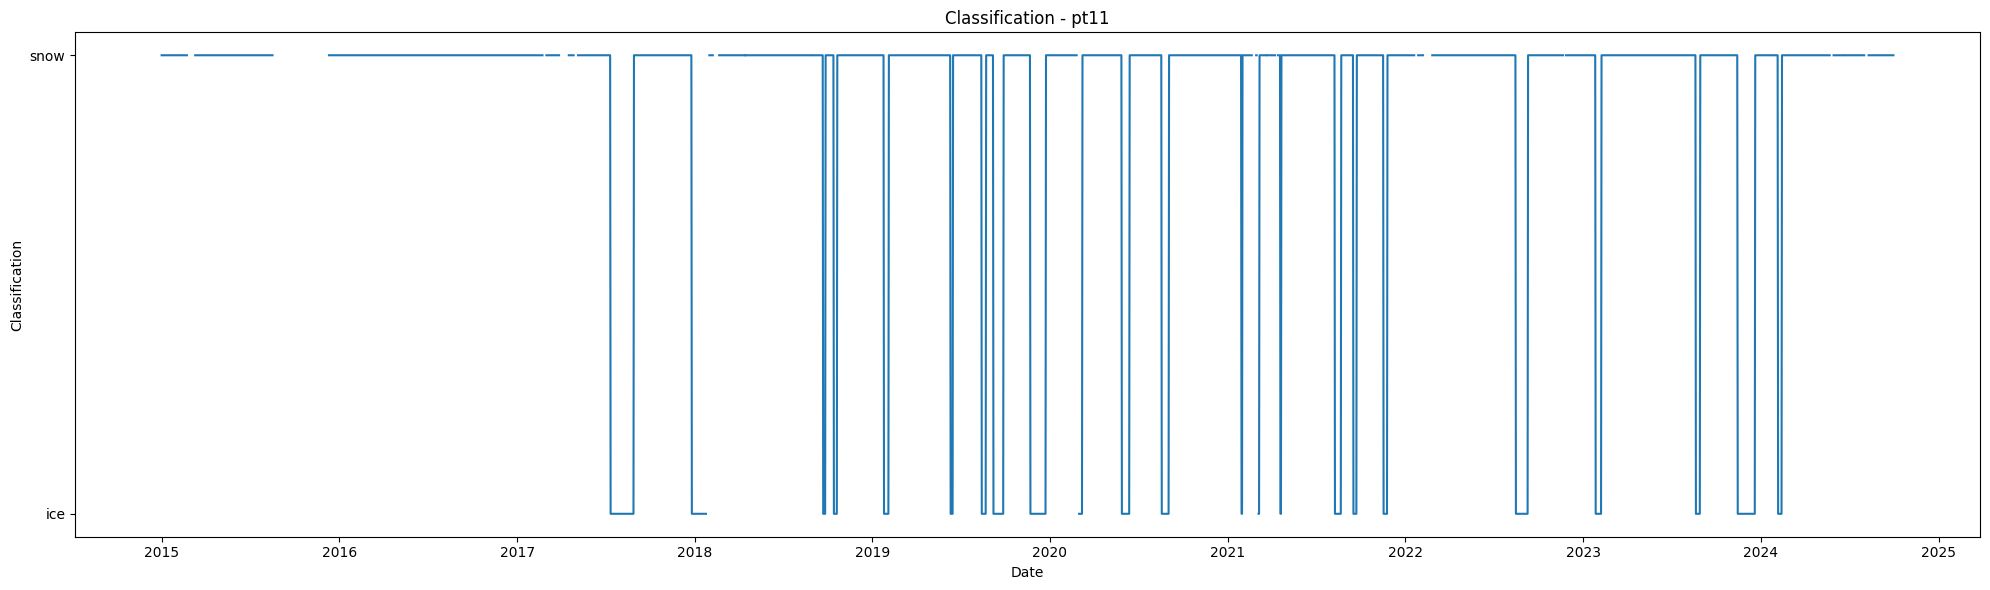

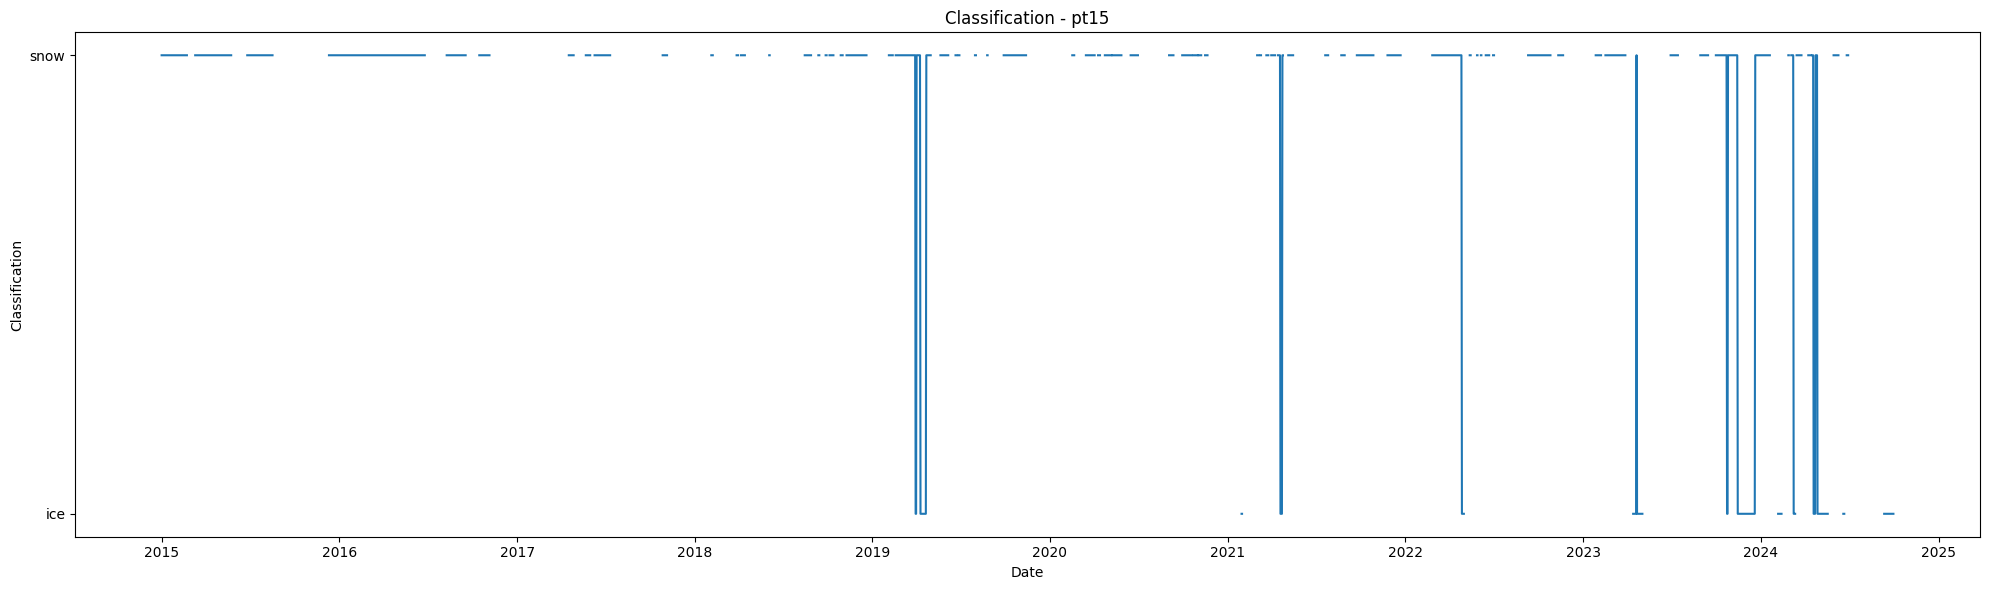

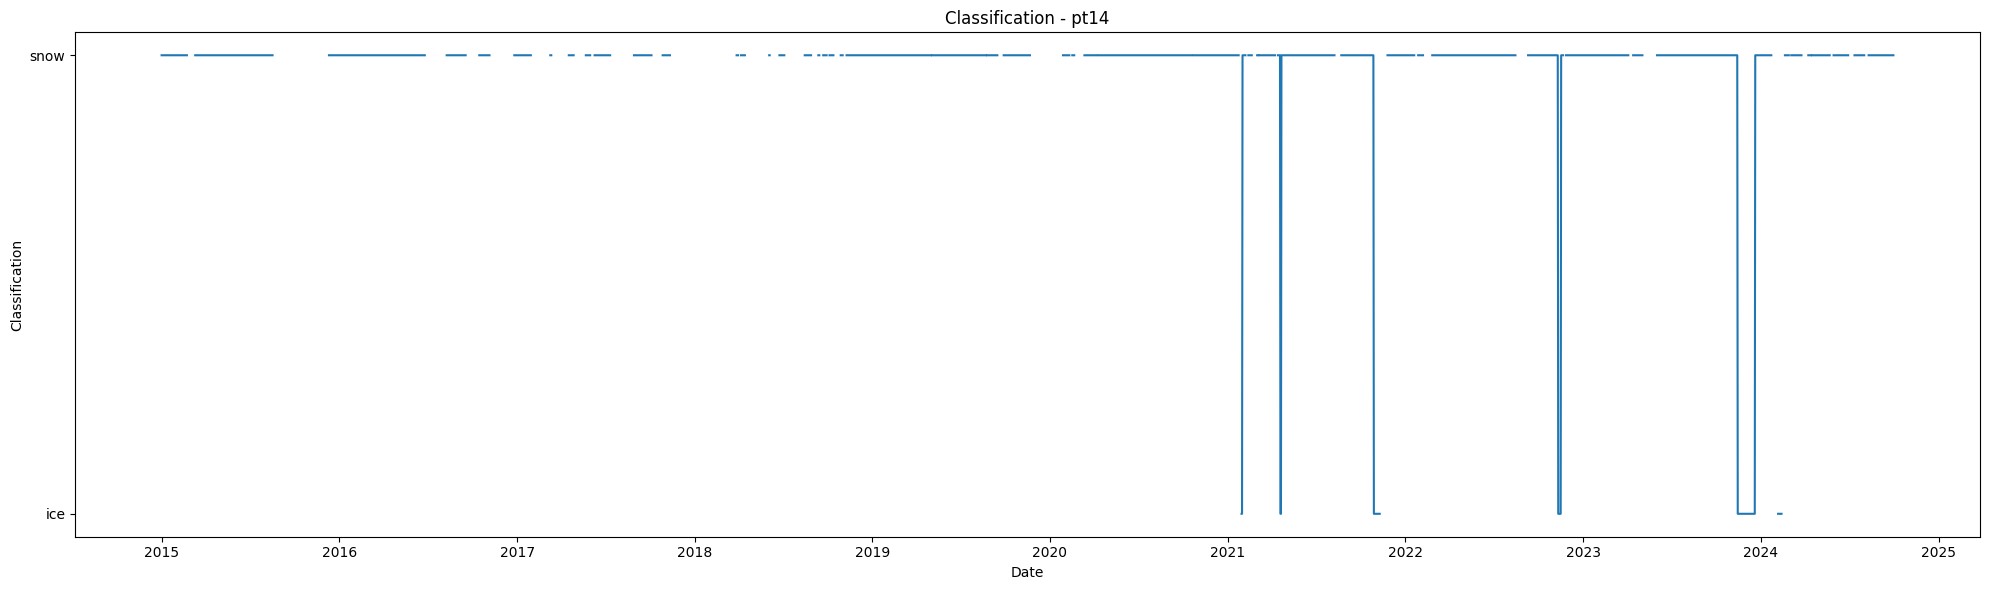

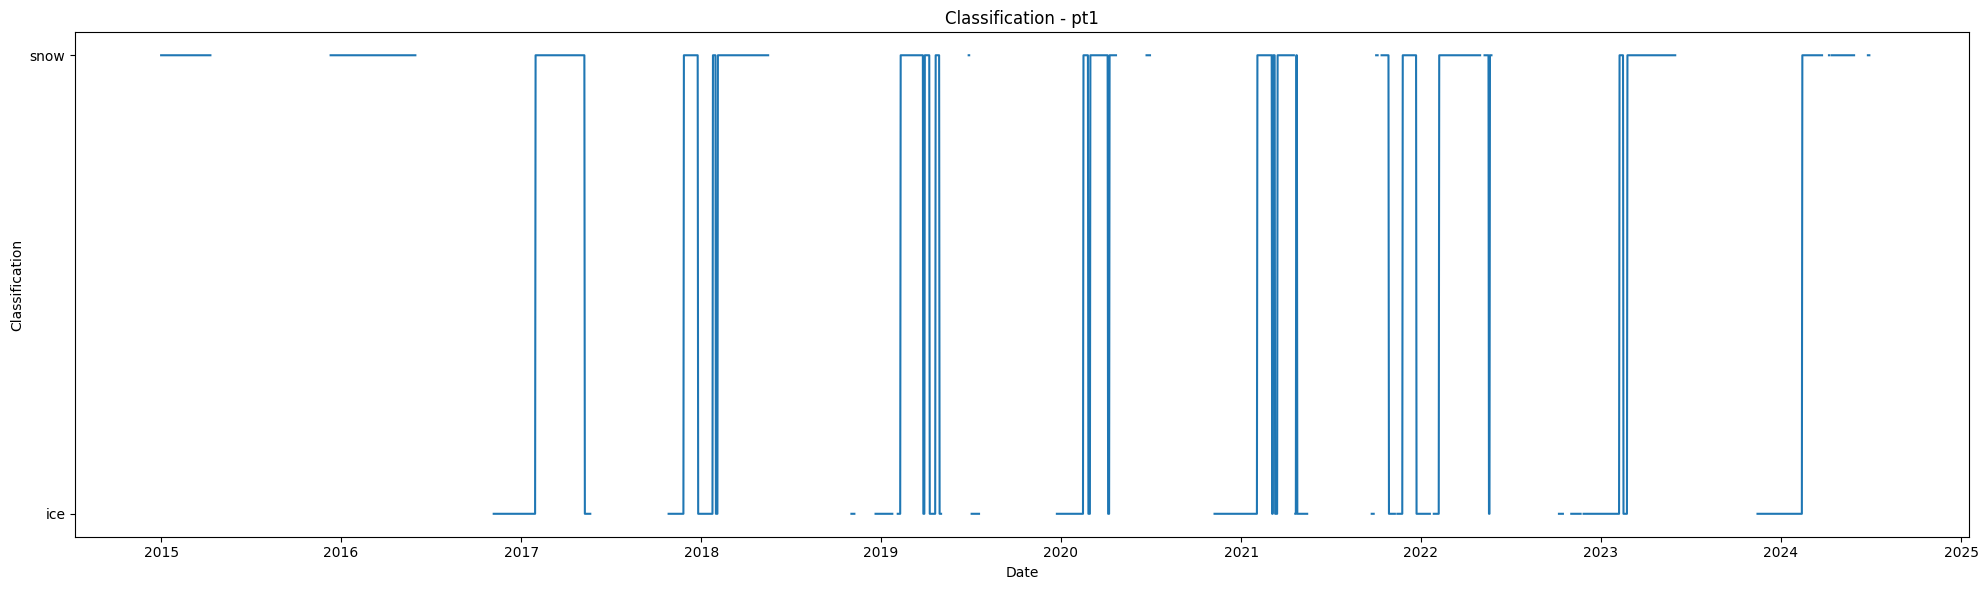

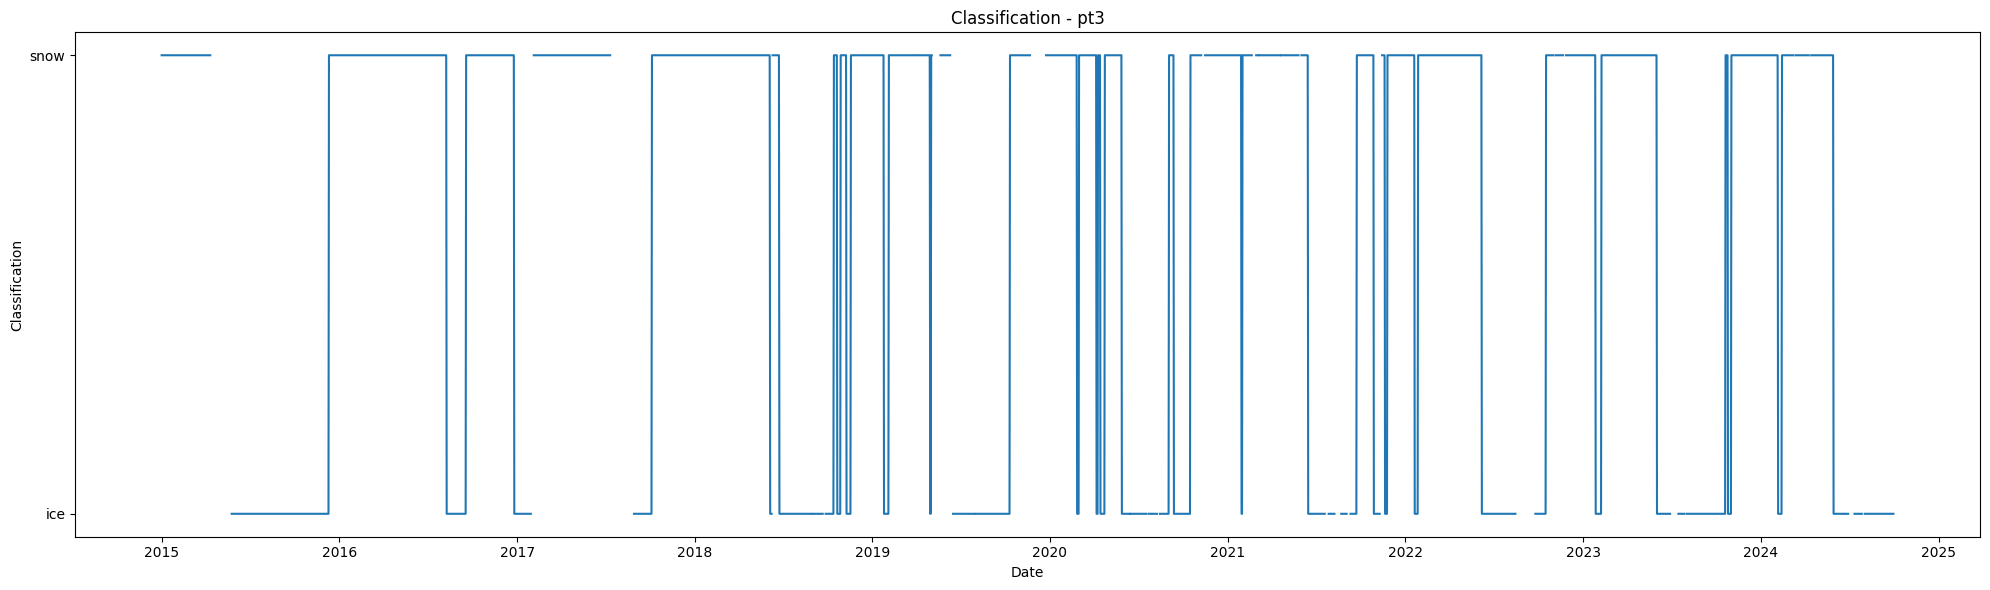

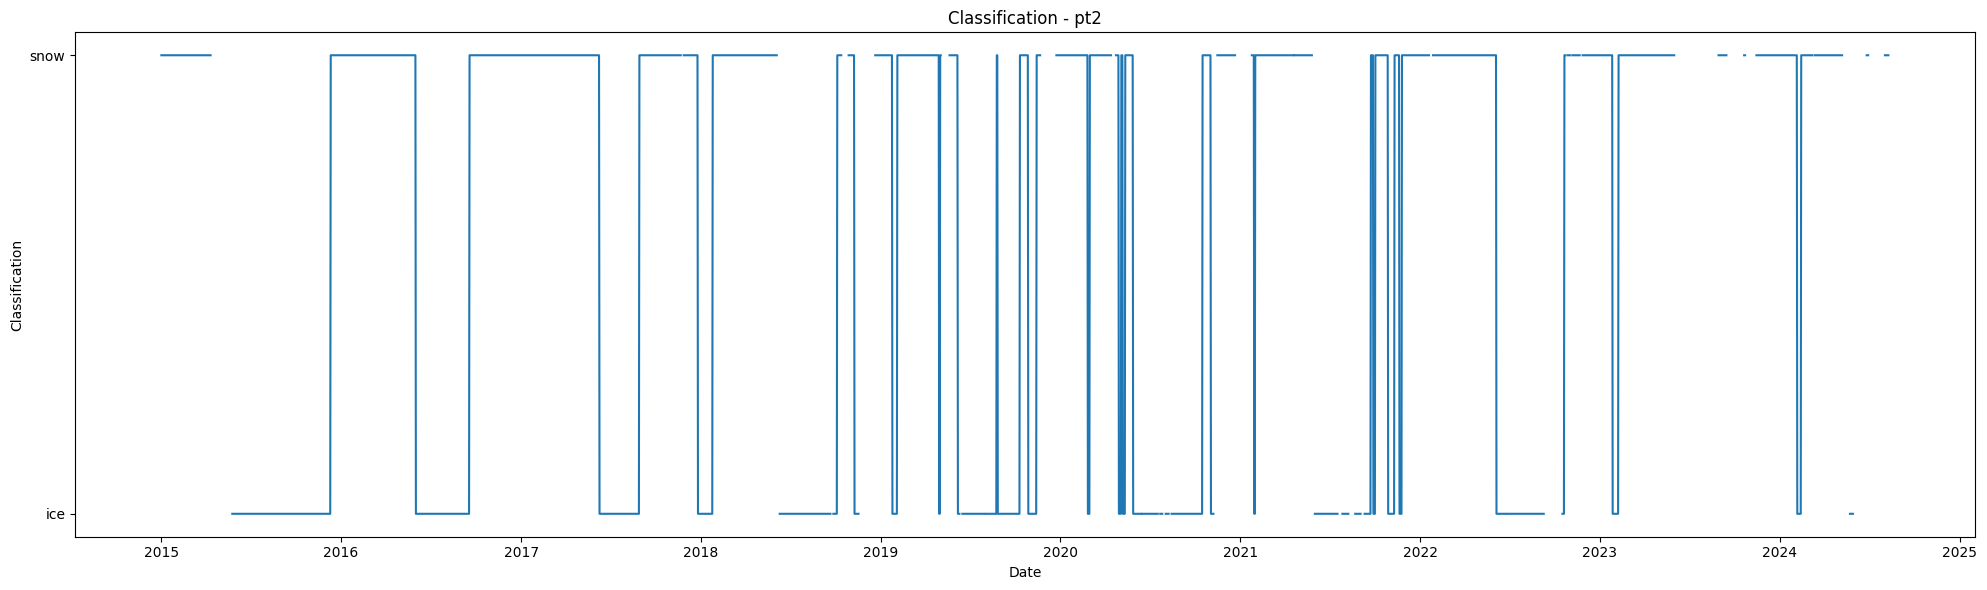

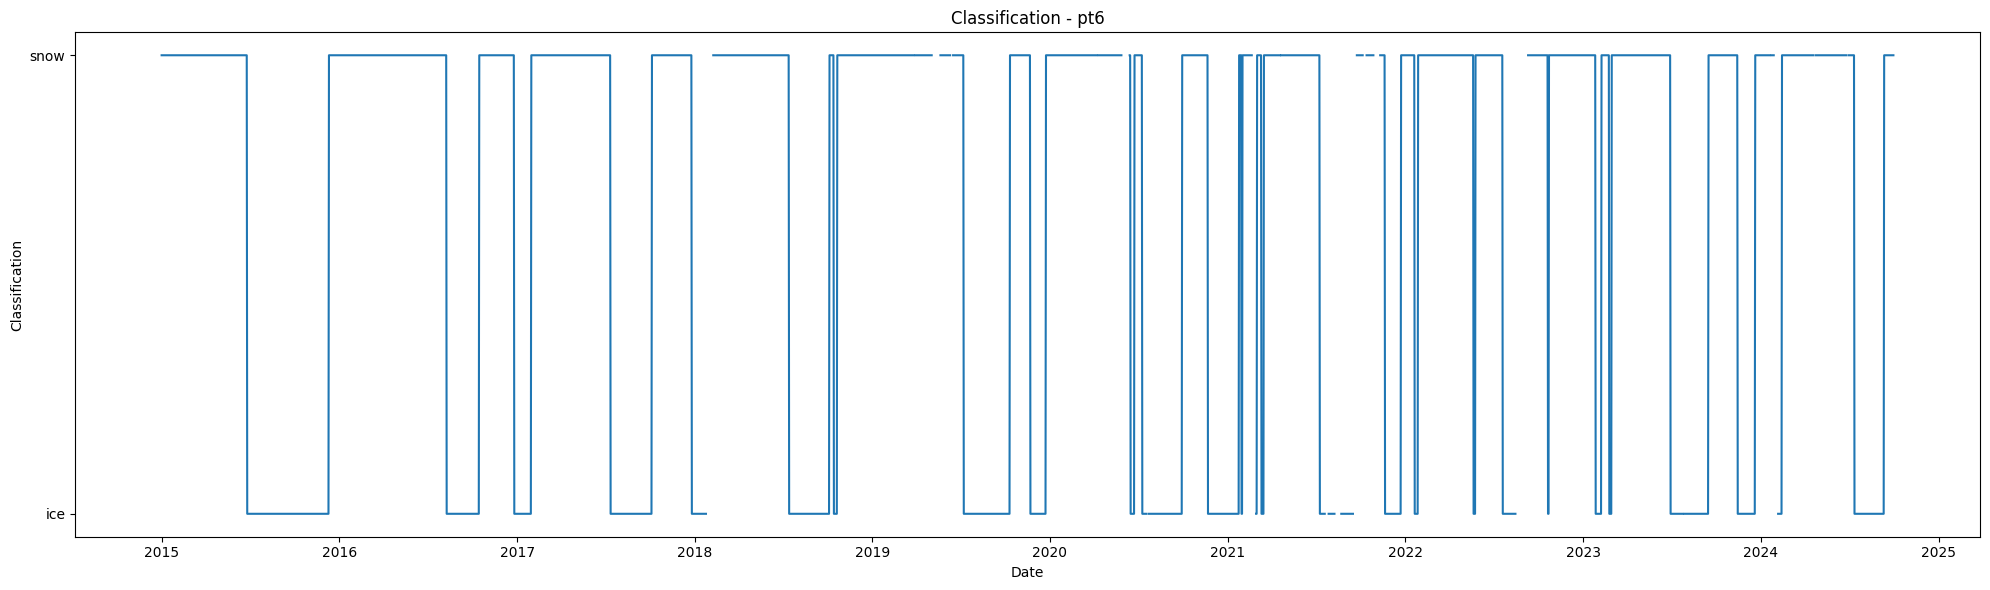

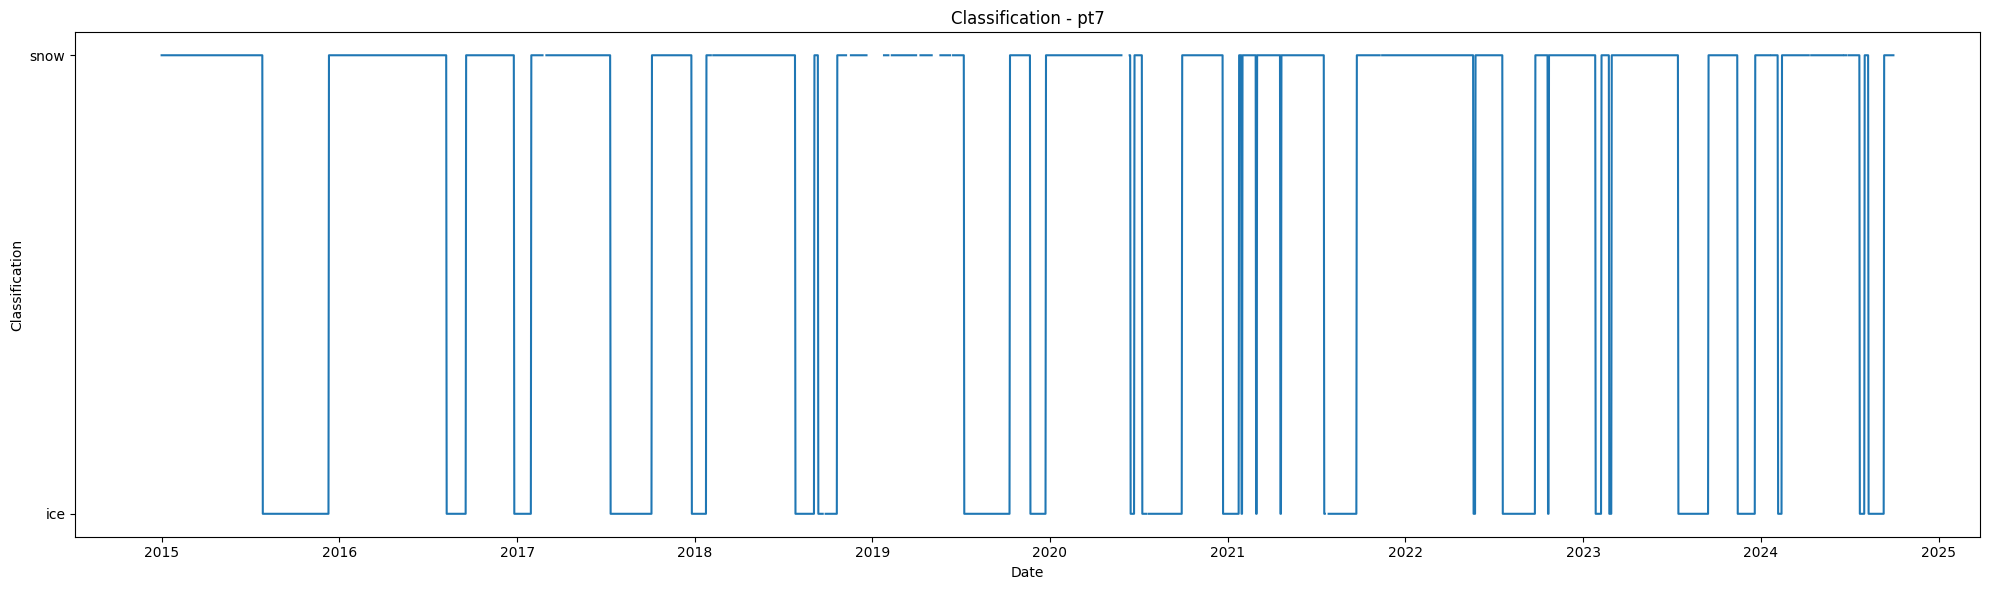

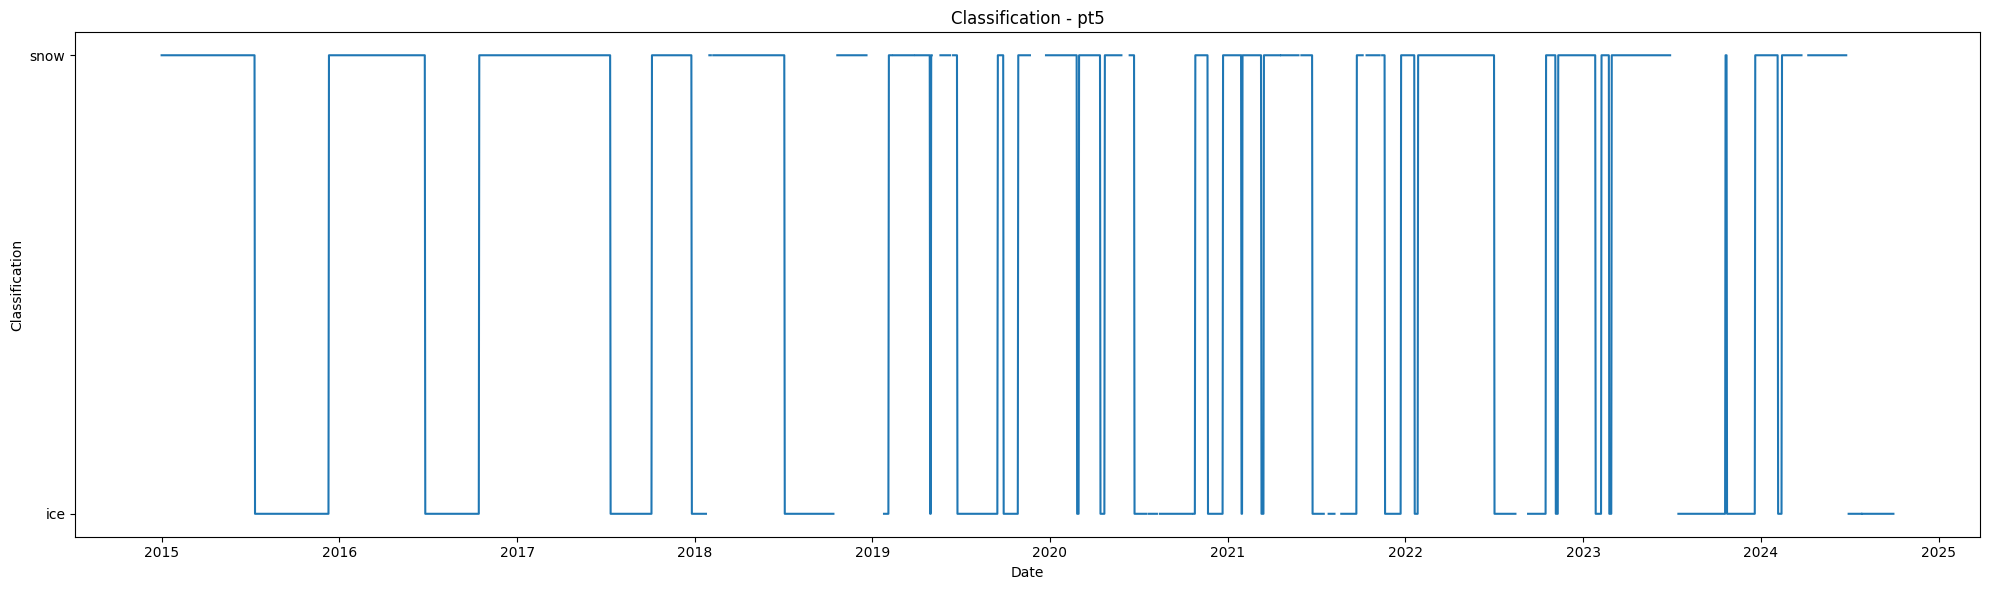

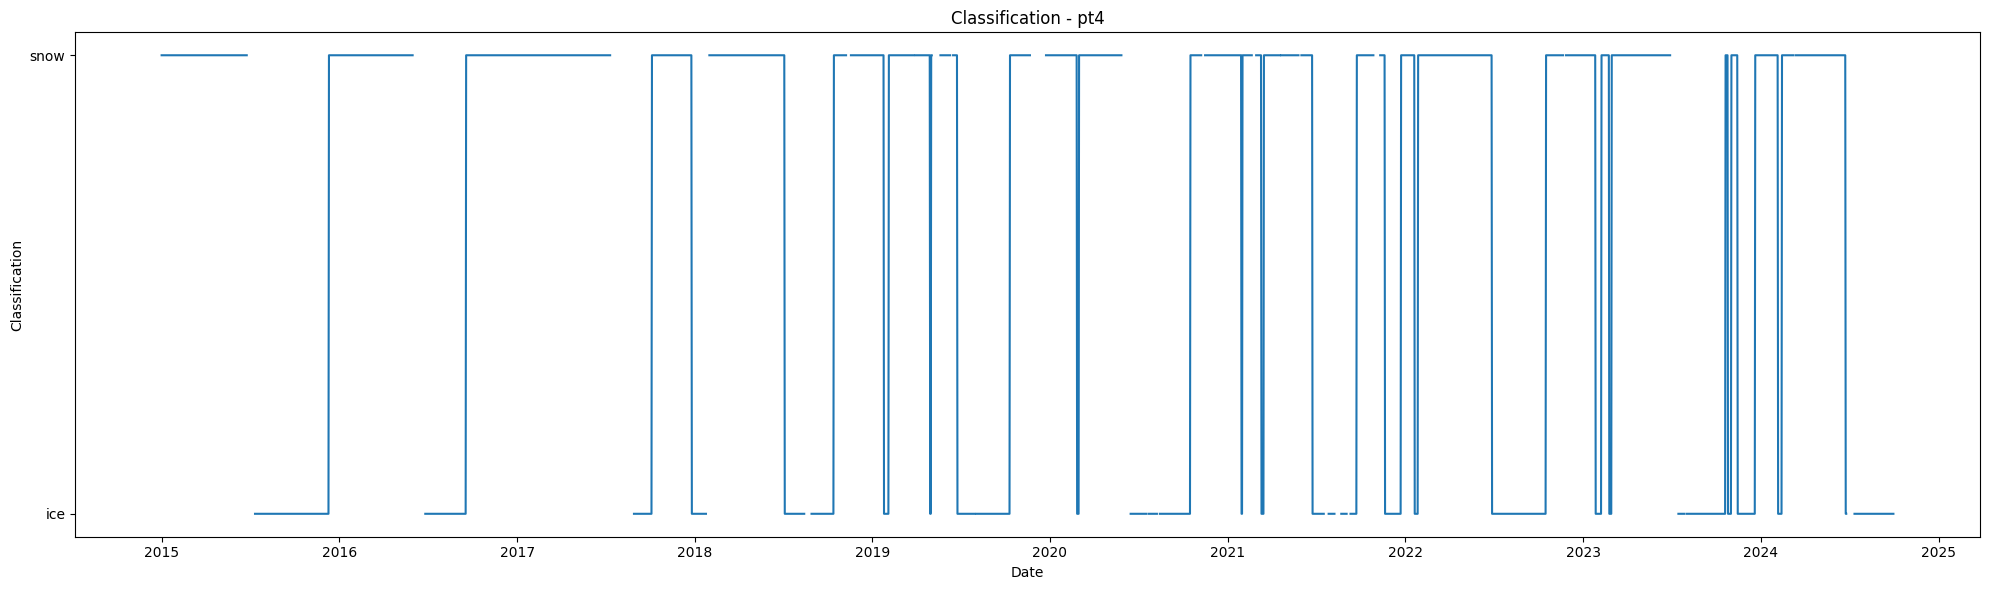

In [21]:
for pt_name, pt_df in temperature_and_class.items():
    plt.figure(figsize=(20, 6))
    plt.title(f'Classification - {pt_name}')
    plt.xlabel('Date')
    plt.ylabel('Classification')
    
    #plot classification over time
    plt.plot(pt_df['time'], pt_df['class'])  # second column after 'time'
    
    plt.yticks([1,2], ['ice', 'snow'])
    plt.tight_layout()
    plt.show()

## PDD function

In [22]:
#function to calculate PDD
def pdd(temperature, ddf):
    """
    Calculates melt using the Positive Degree Day model.

    Parameters:
        temperature (array-like): Daily temperature data in degrees Celsius.
        ddf (float): Degree-Day Factor, typically in mm/°C/day.

    Returns:
        array-like: Daily melt in mm.
    """

    #calculate positive degree days (°C)
    pdd = np.maximum(temperature, 0)

    #calculate melt [PDD (°C) /  ddf (mm w.e. °C-1) = melt (mm w.e.)]
    melt = pdd * ddf

    return melt

## calculate melt using PDD

In [23]:
#dictionary to store melt estimation results
melt_data = {}

#loop through each point in merged data dictionary
for pt_name, df in temperature_and_class.items():
    melt_values = []
    last_ddf = None

    #loop through each row in the df
    for i in range(len(df)):
        temperature = df['temperature'].iloc[i]
        current_class = df['class'].iloc[i]

        if current_class == 1:
            current_ddf = ddf_ice
        elif current_class == 2:
            current_ddf = ddf_snow
        elif pd.isna(current_class):
            if last_ddf is not None:
                current_ddf = last_ddf
            else:
                melt_values.append(np.nan)
                continue
        else:
            melt_values.append(np.nan)
            last_ddf = None
            continue

        #calculate melt
        daily_melt = pdd(temperature, current_ddf)
        melt_values.append(daily_melt)

        #save last valid DDF
        if not pd.isna(current_class):
            last_ddf = current_ddf

    #add melt column to df
    df['melt'] = melt_values
    df['time'] = pd.to_datetime(df['time'])

    #store
    melt_data[pt_name] = df

## plot melt for each point

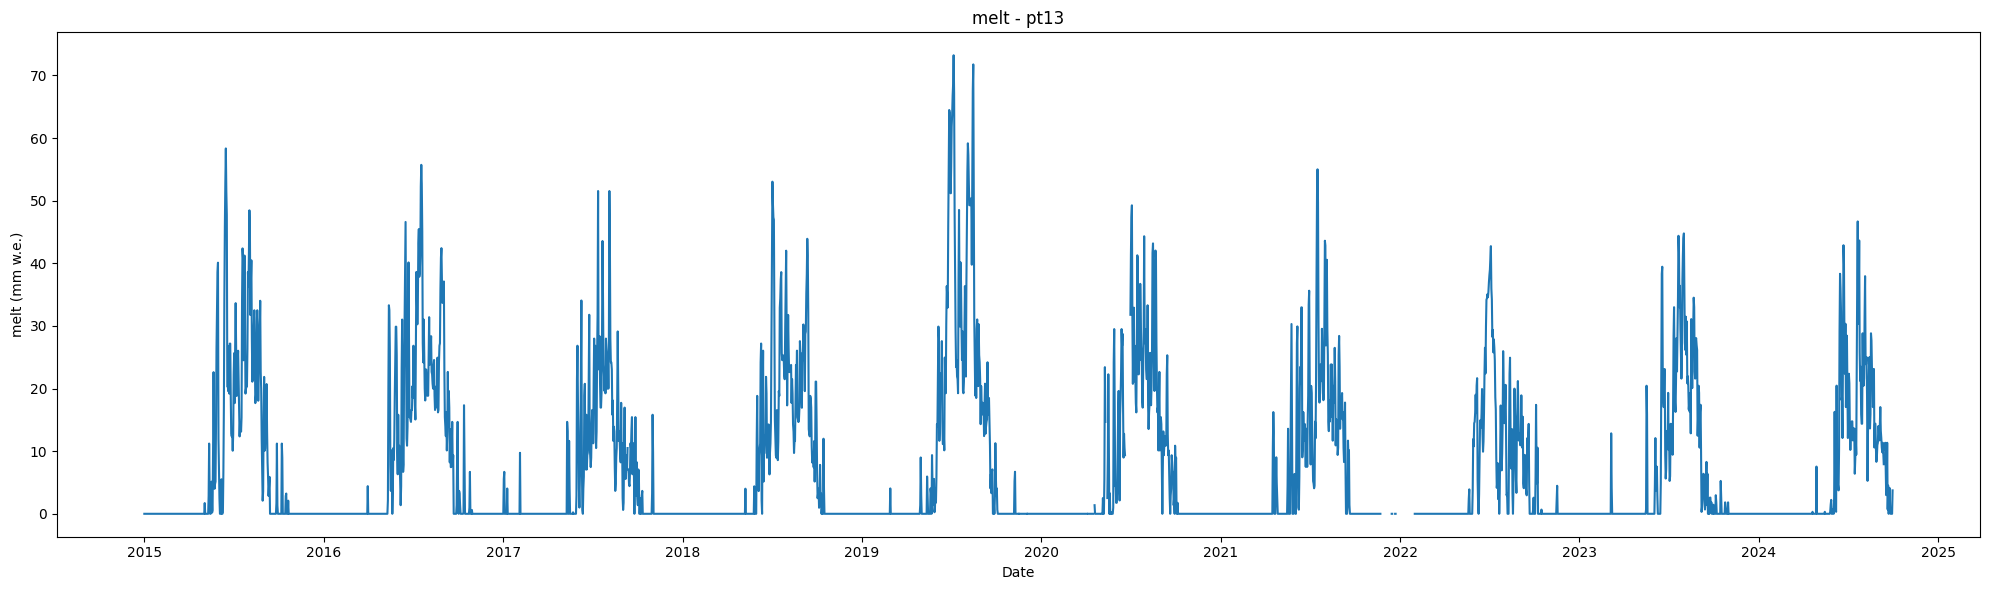

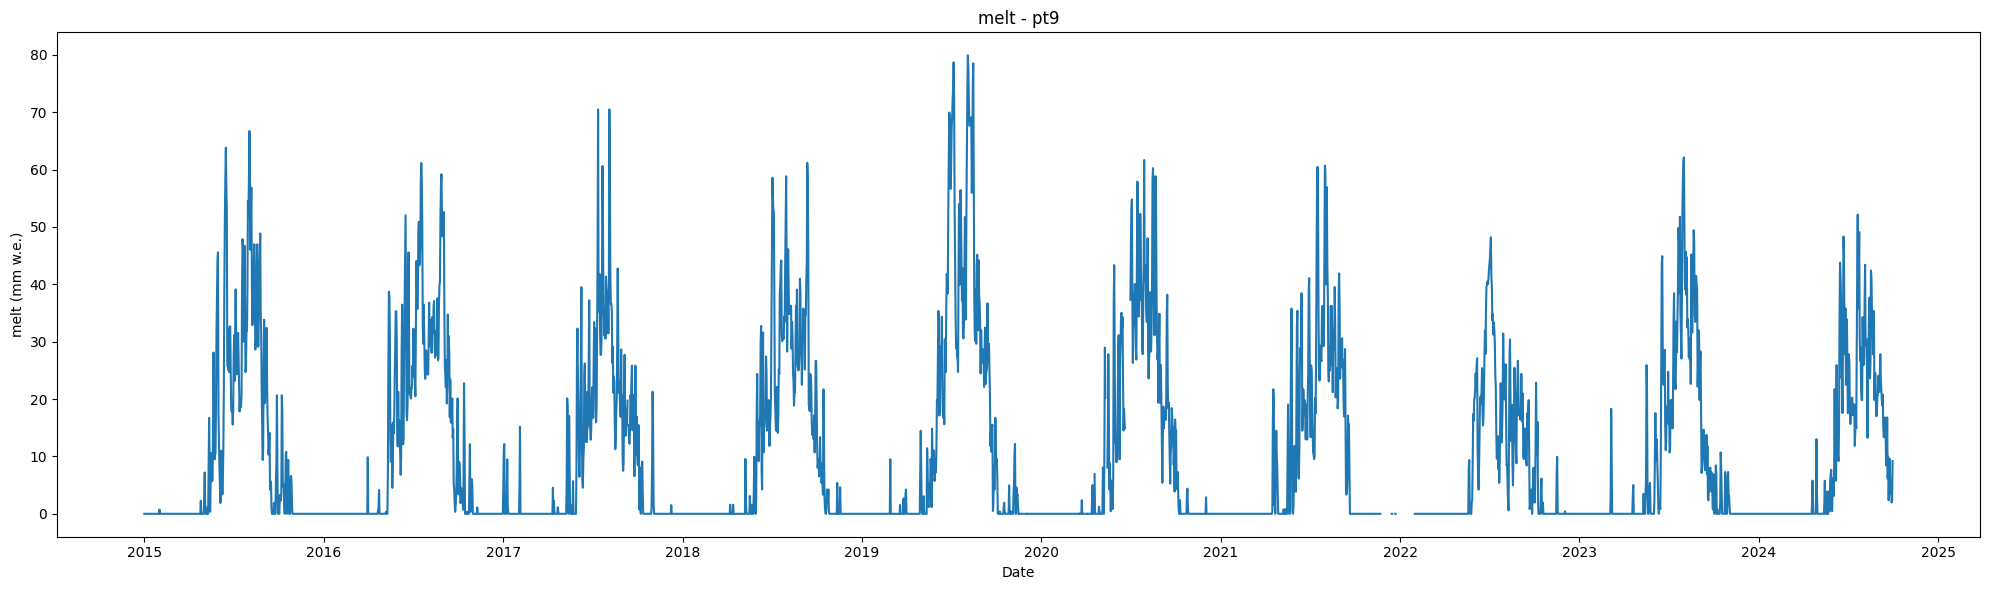

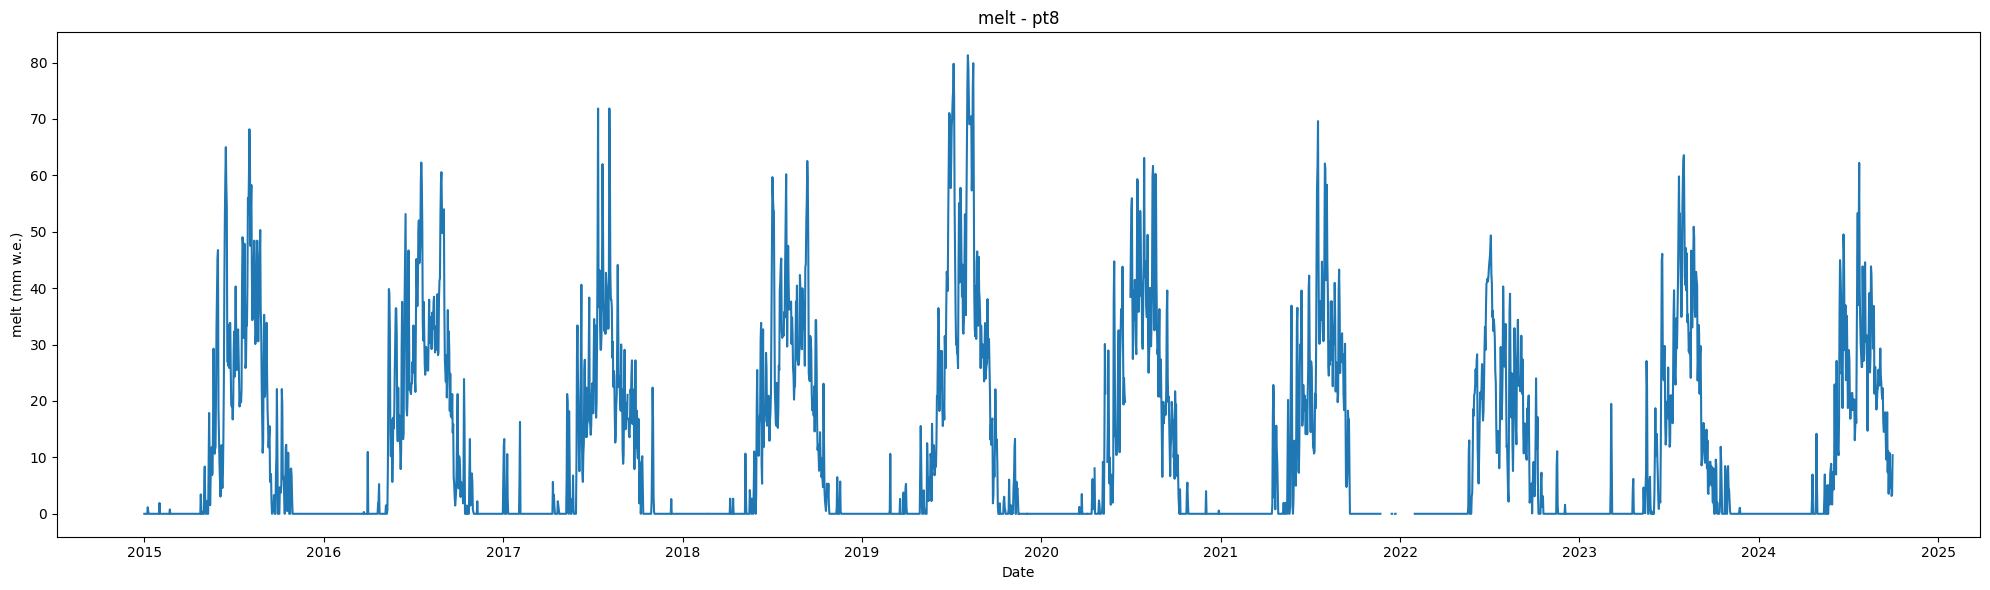

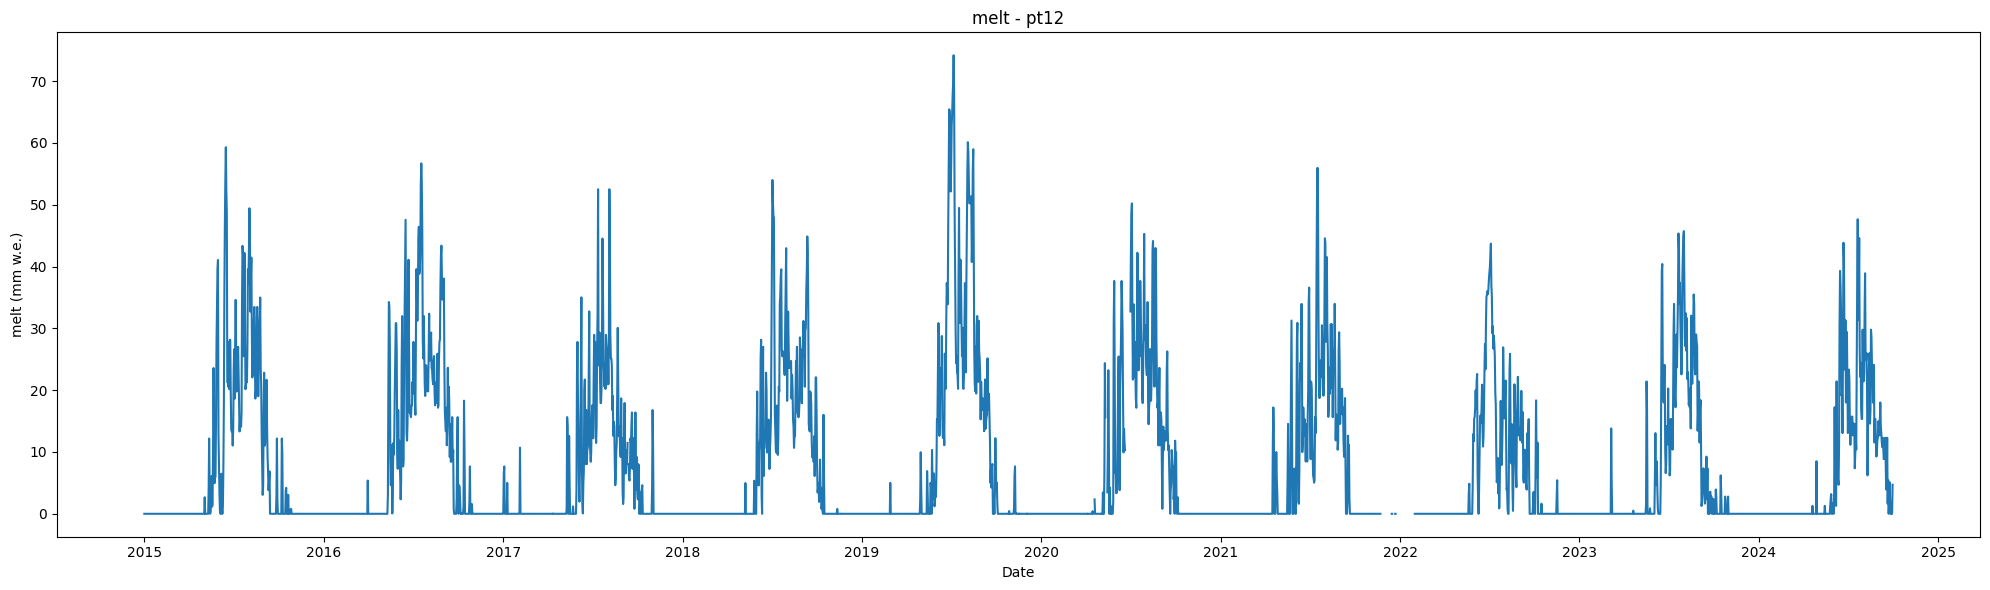

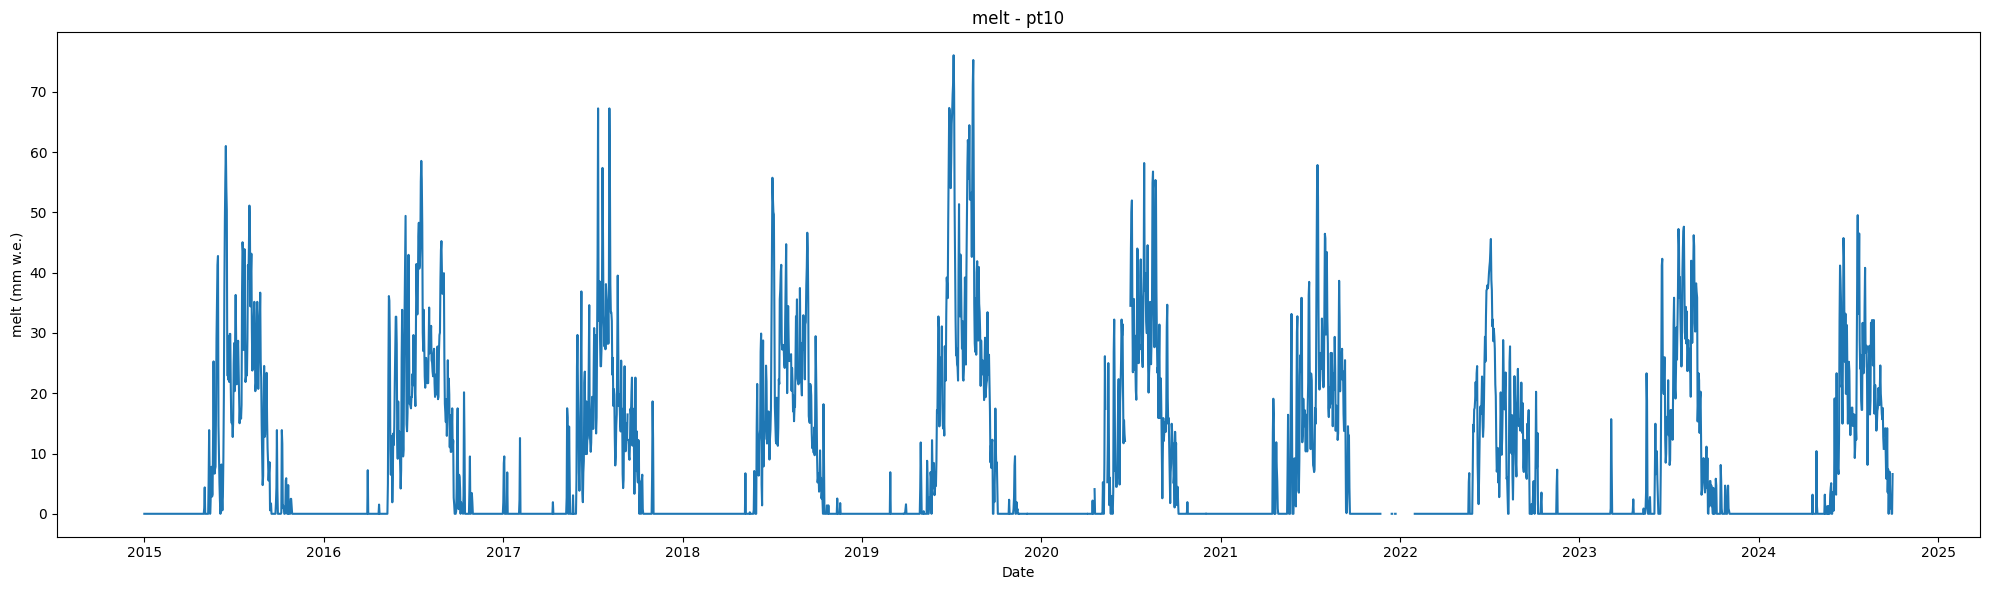

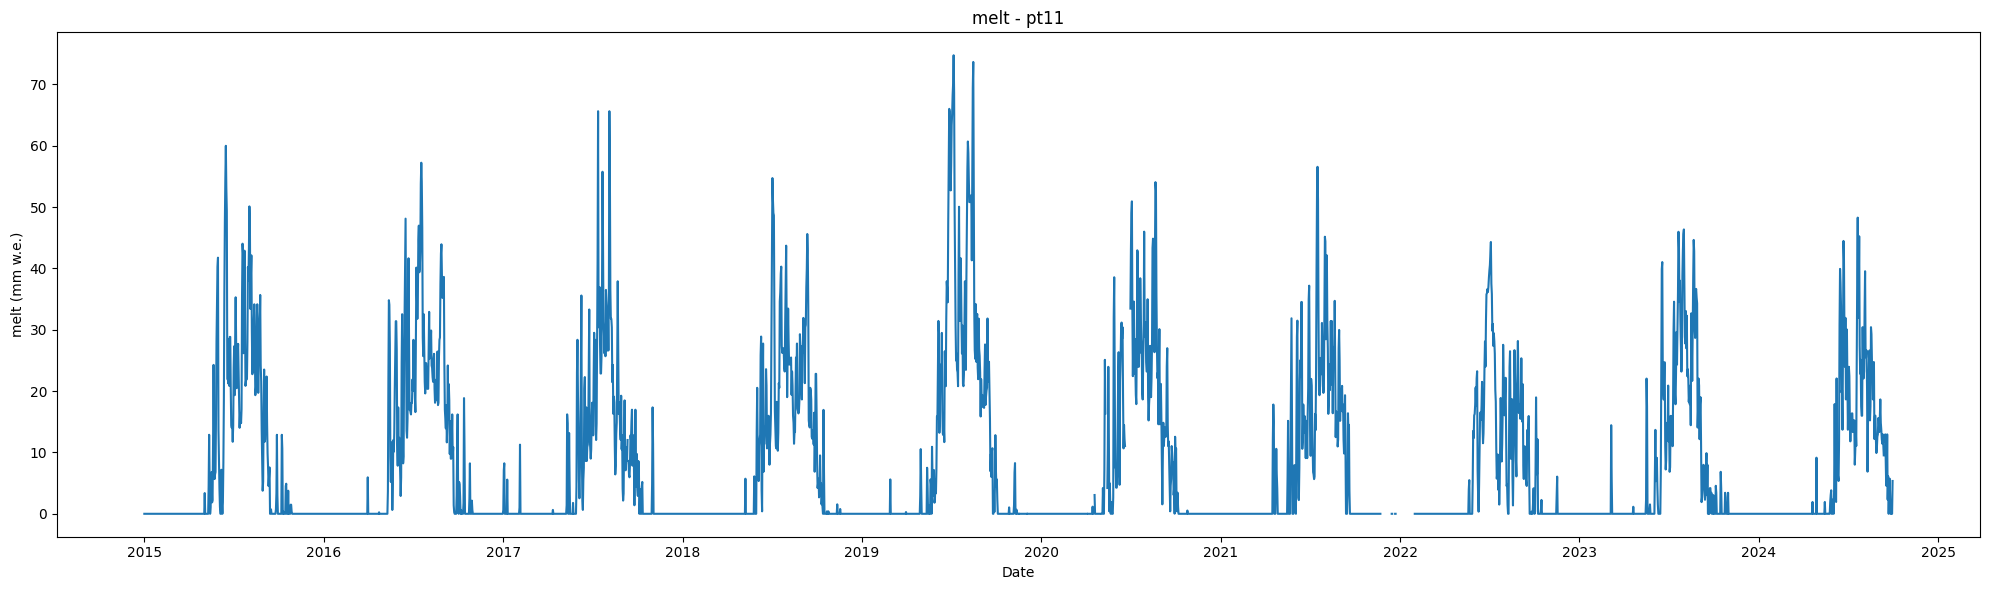

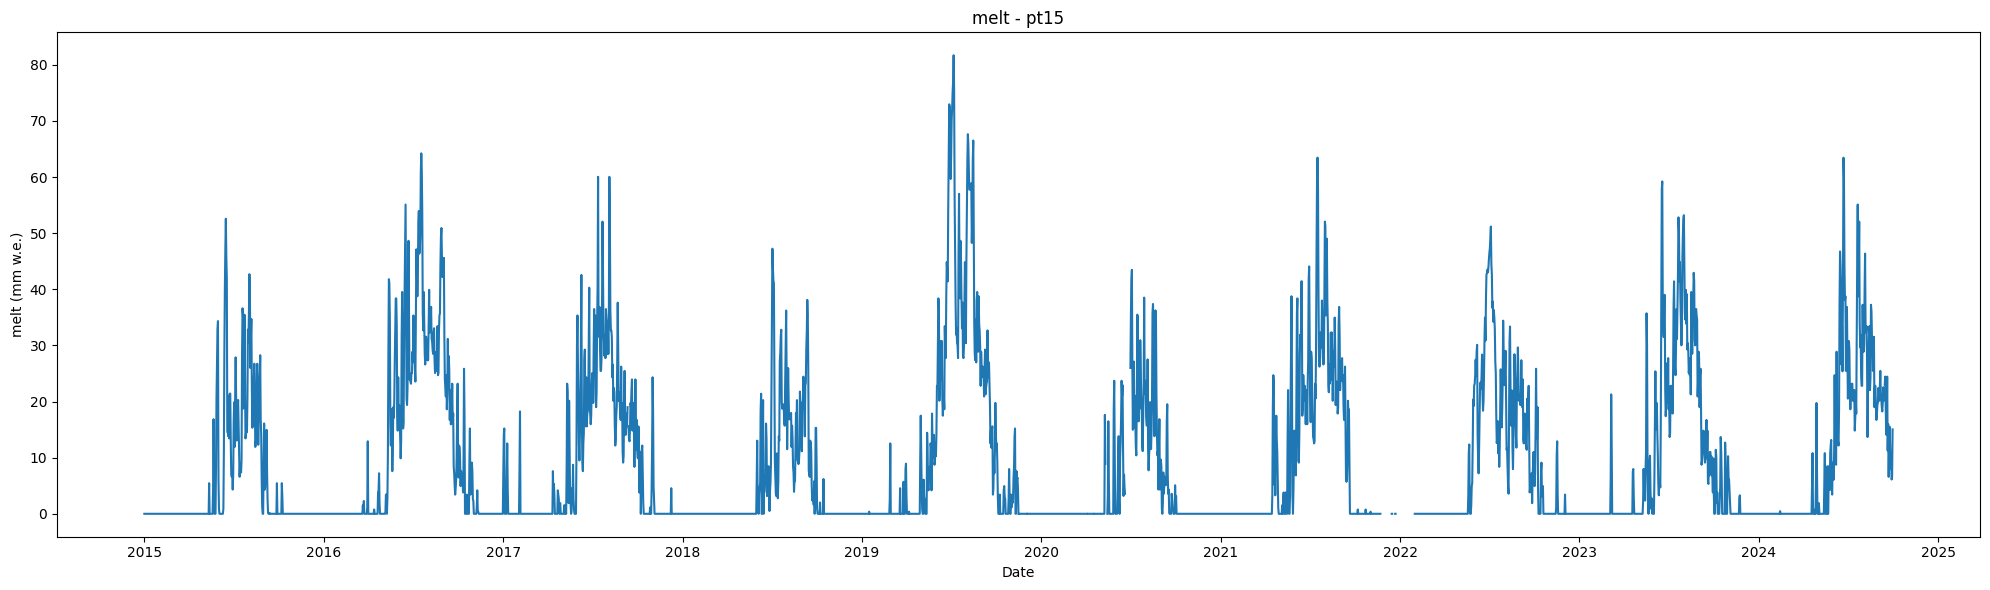

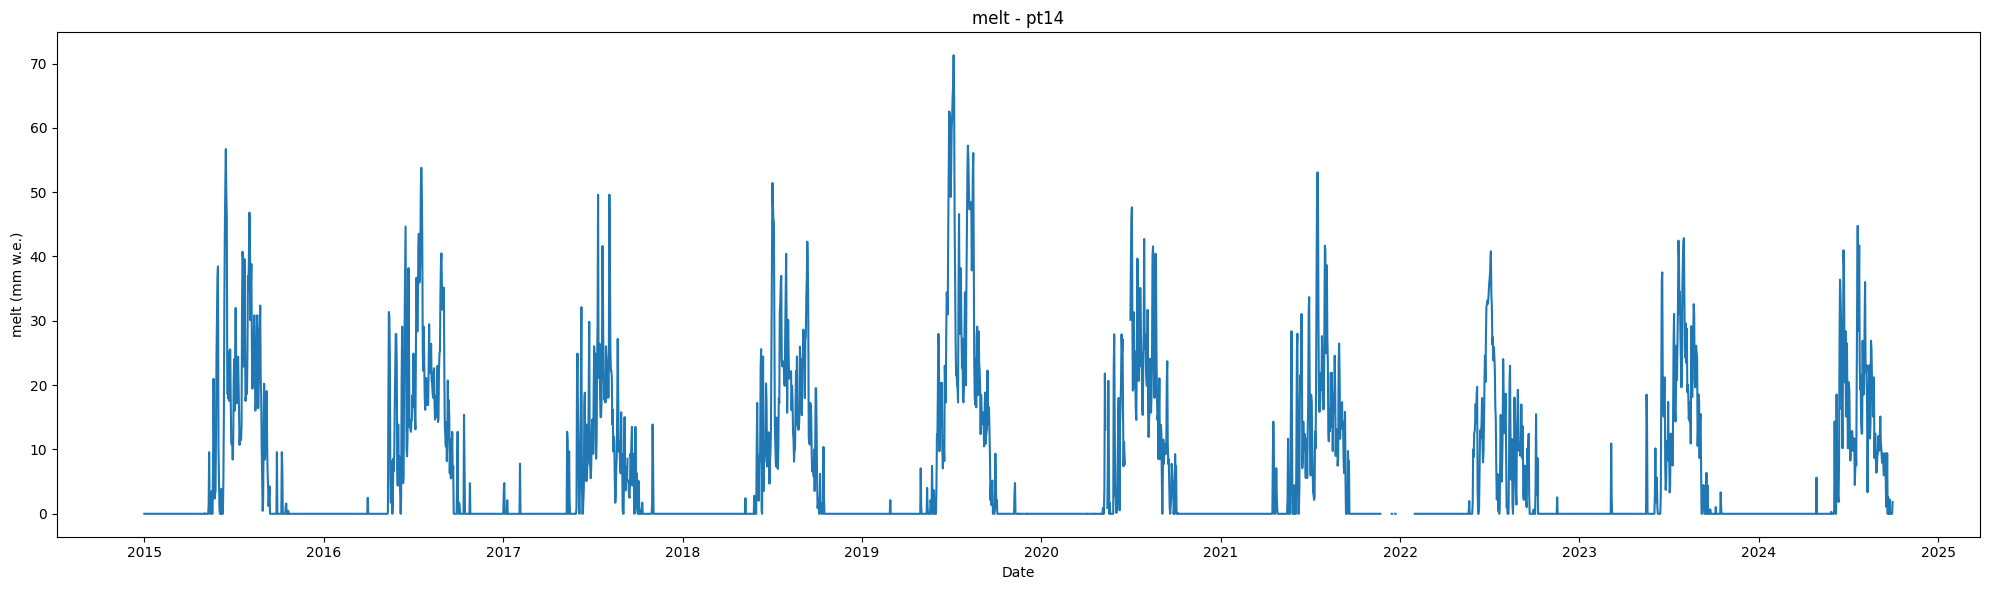

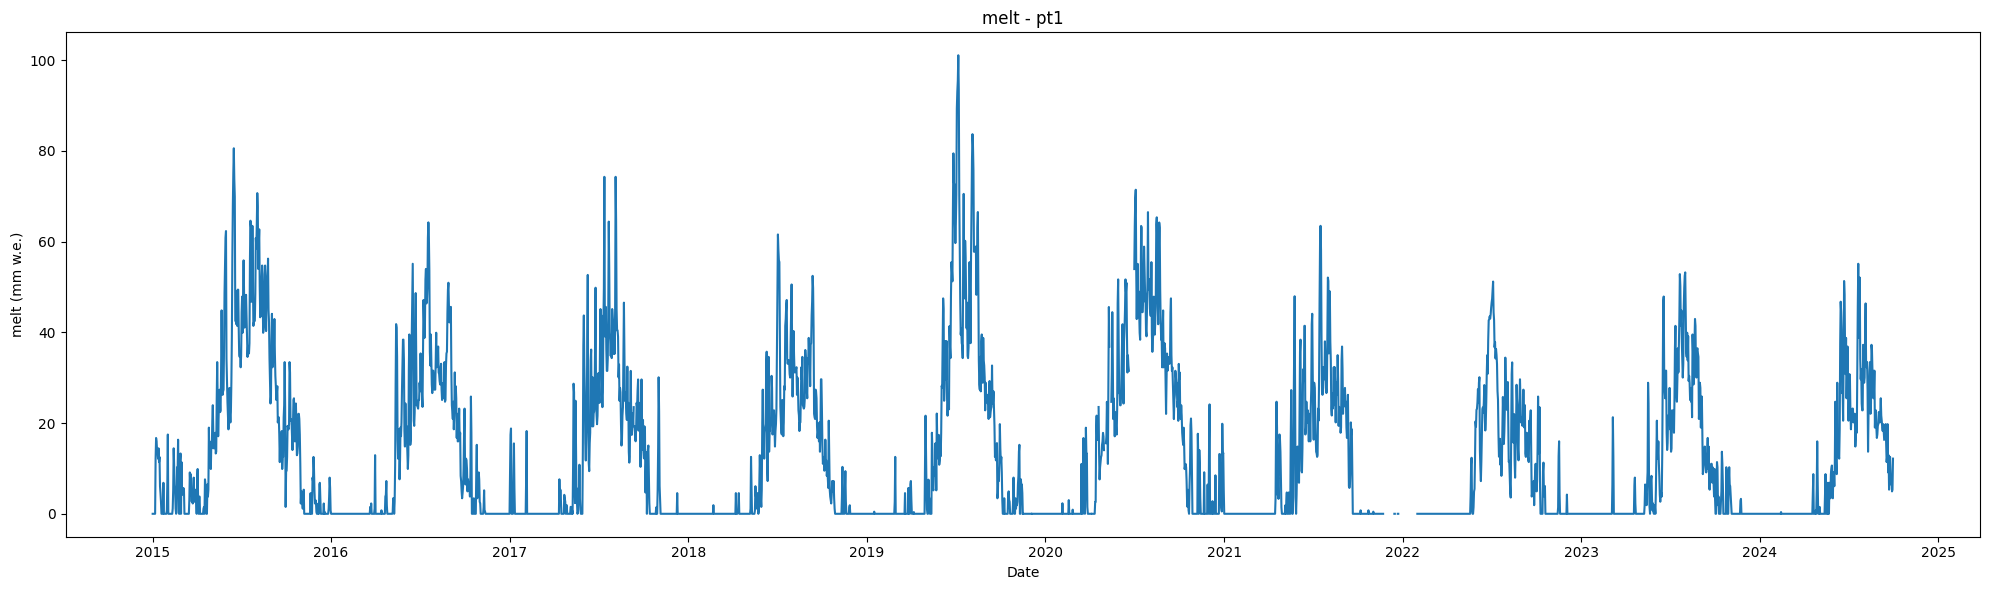

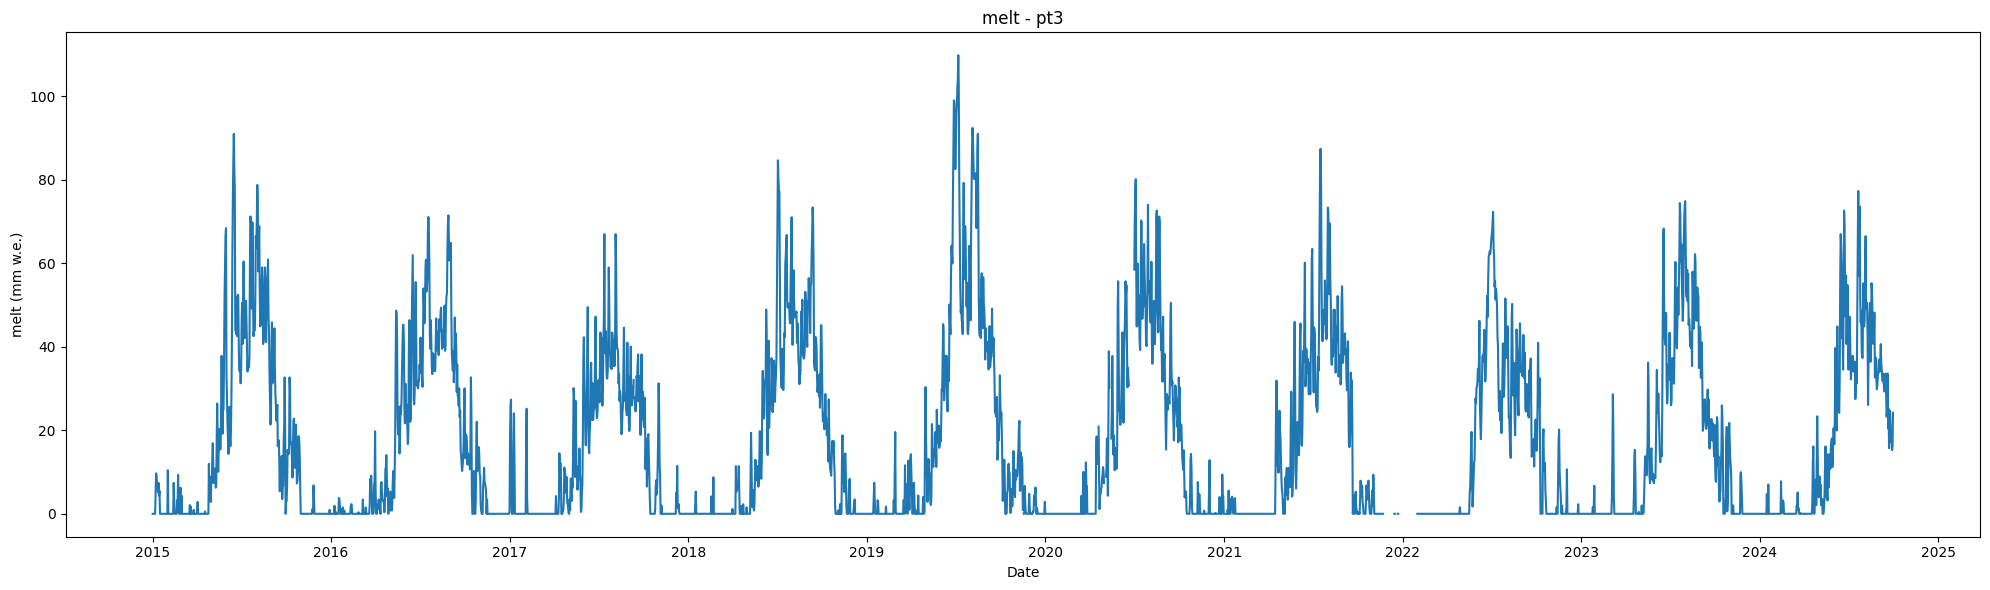

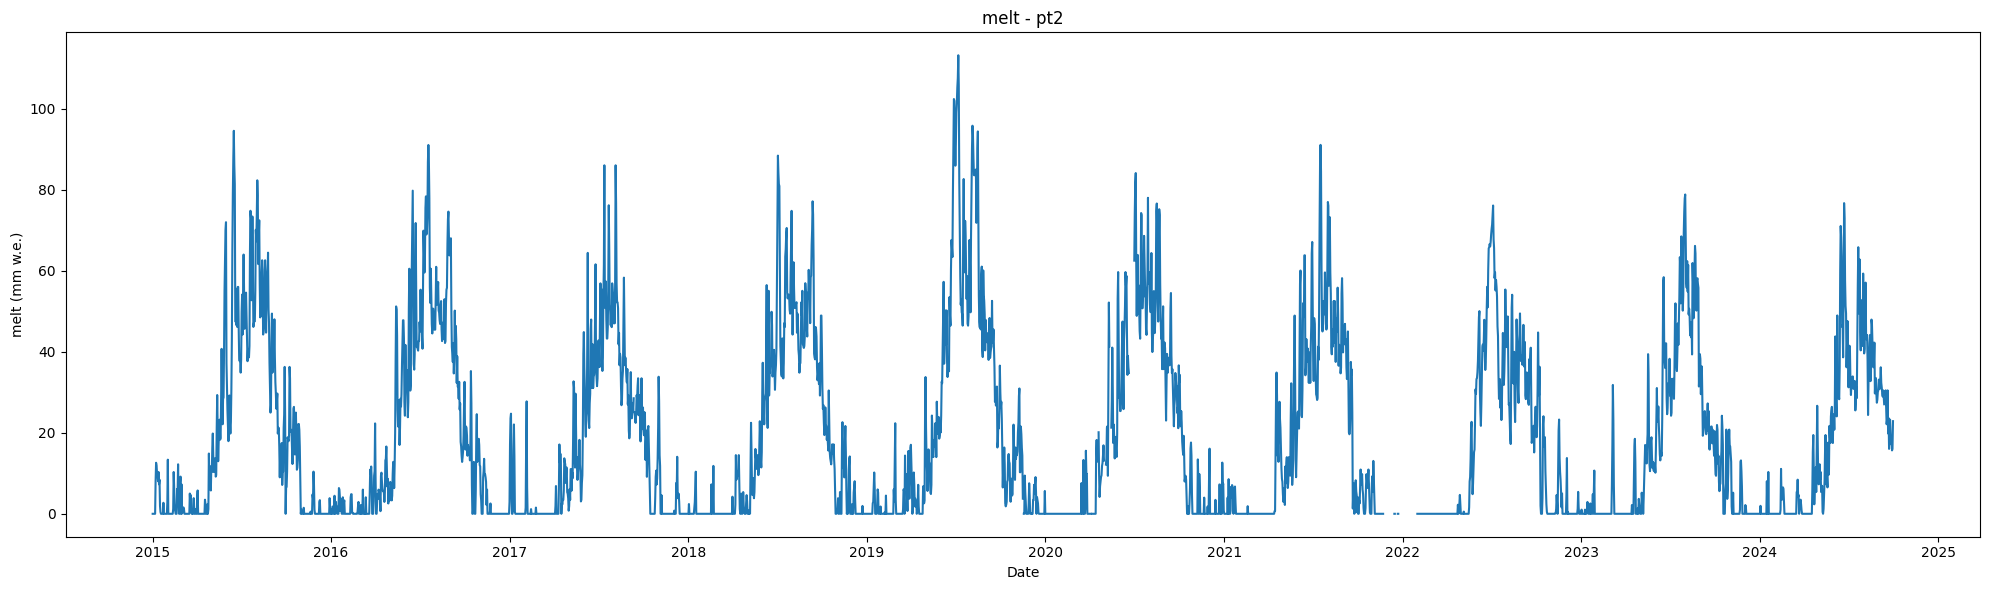

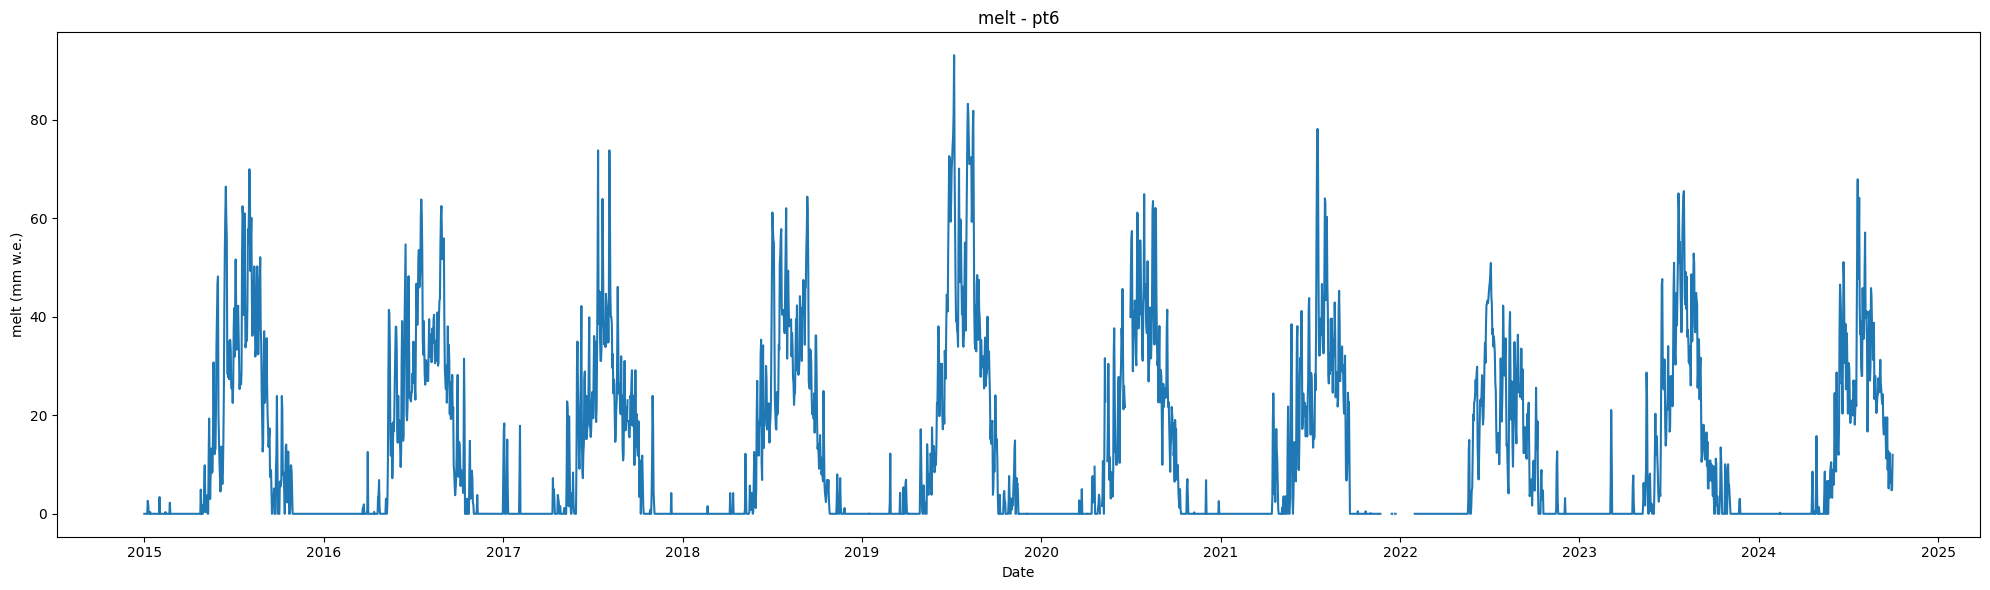

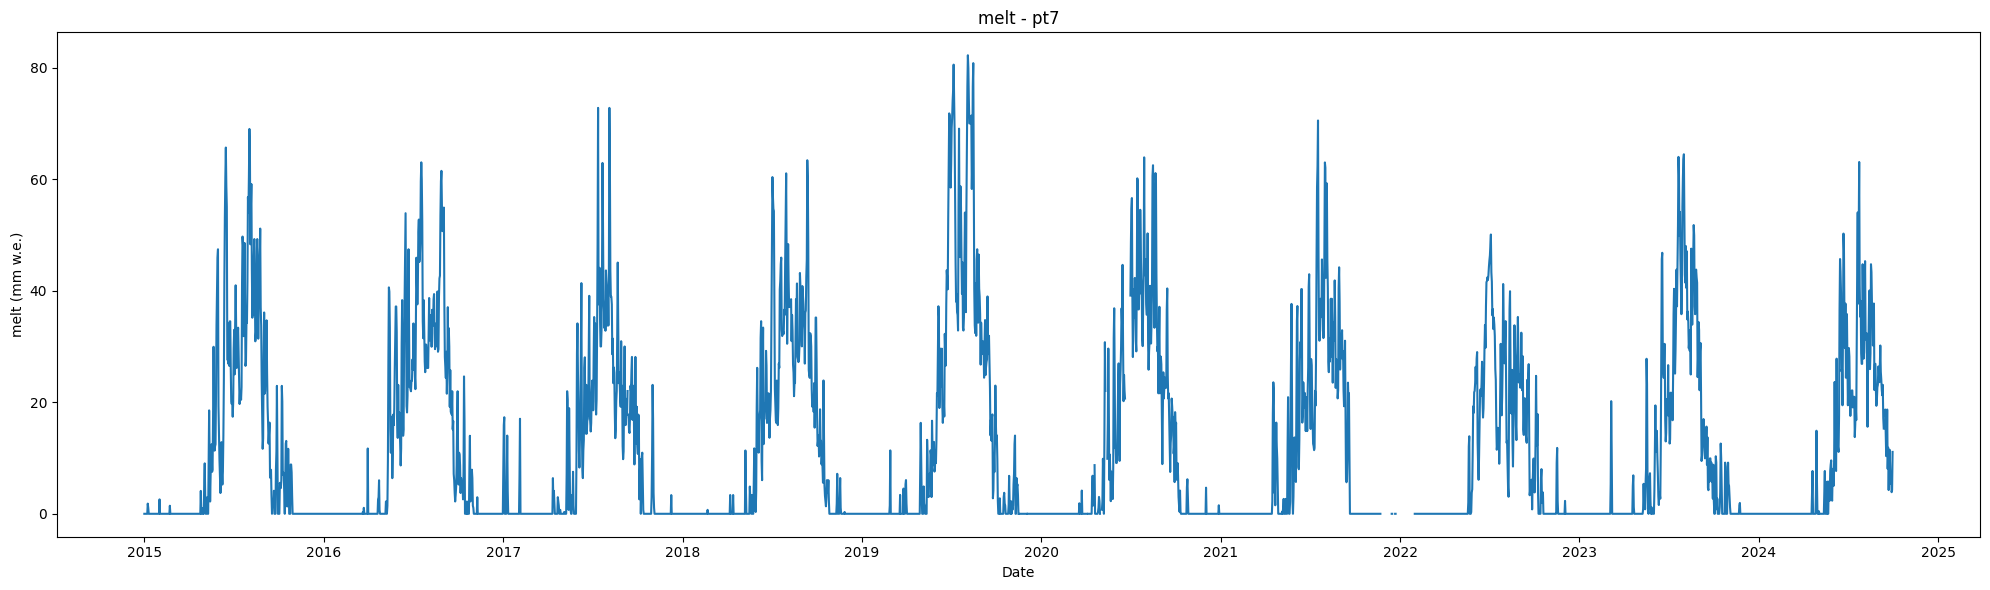

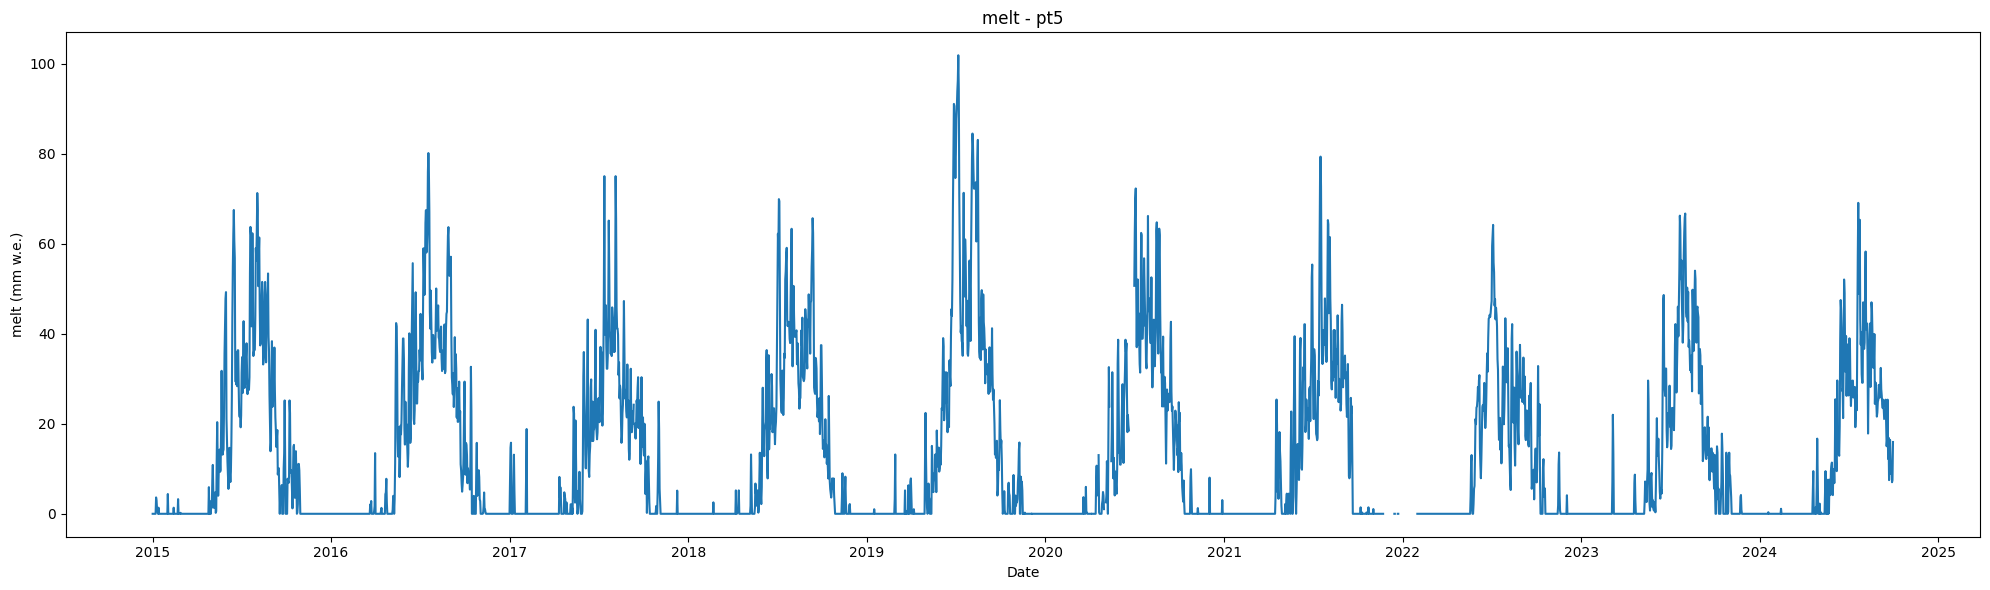

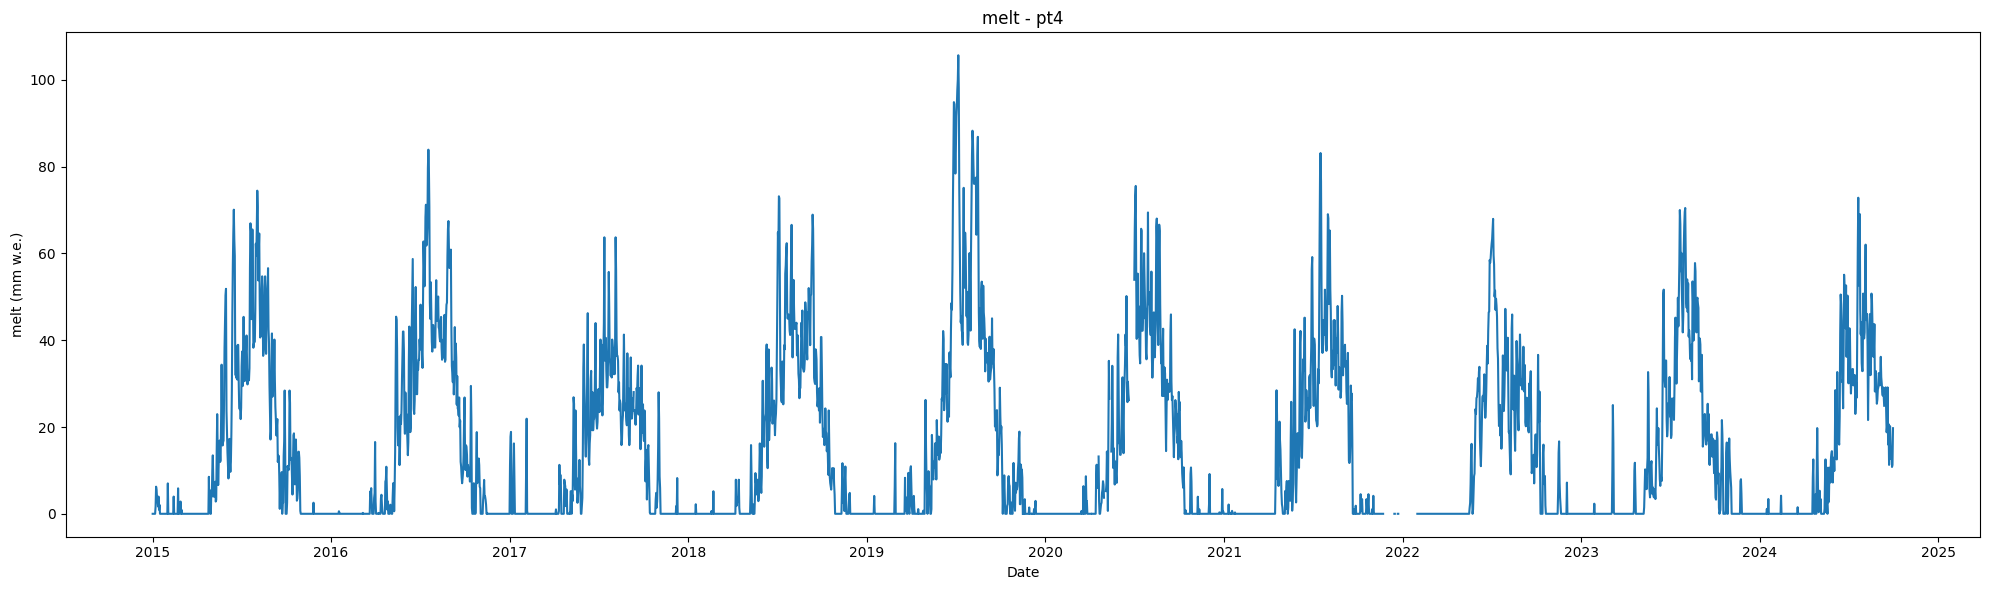

In [24]:
for pt_name, pt_df in melt_data.items():
    plt.figure(figsize=(20, 6))
    plt.title(f'melt - {pt_name}')
    plt.xlabel('Date')
    plt.ylabel('melt (mm w.e.)')
    plt.plot(pt_df['time'], pt_df['melt'])  # second column after 'time'
    plt.tight_layout()
    plt.show()

# export melt estimates

In [25]:
#export melt time series
for pt_name, df in melt_data.items():
    melt_and_time = df[['time','melt']]
    melt_and_time.to_csv(f'{out_path}{pt_name}_melt.csv', index=False)

# calculate annual total melt

In [26]:
#total melt for each point each year (integrate under melt curves)
total_melt = {}

for pt_name, df in melt_data.items():
    # Extract all unique years from the time column
    years = df['time'].dt.year.unique()

    annual_melt_list = []

    for year in sorted(years):
        start_date = pd.Timestamp(f'{year}-01-01')
        end_date = pd.Timestamp(f'{year}-12-31')

        #filter data for current year
        mask = (df['time'] >= start_date) & (df['time'] <= end_date)
        annual_melt = df.loc[mask, 'melt'].sum()

        annual_melt_list.append({'year': year, 'total_melt': annual_melt})

    #save as df
    total_melt[pt_name] = pd.DataFrame(annual_melt_list)

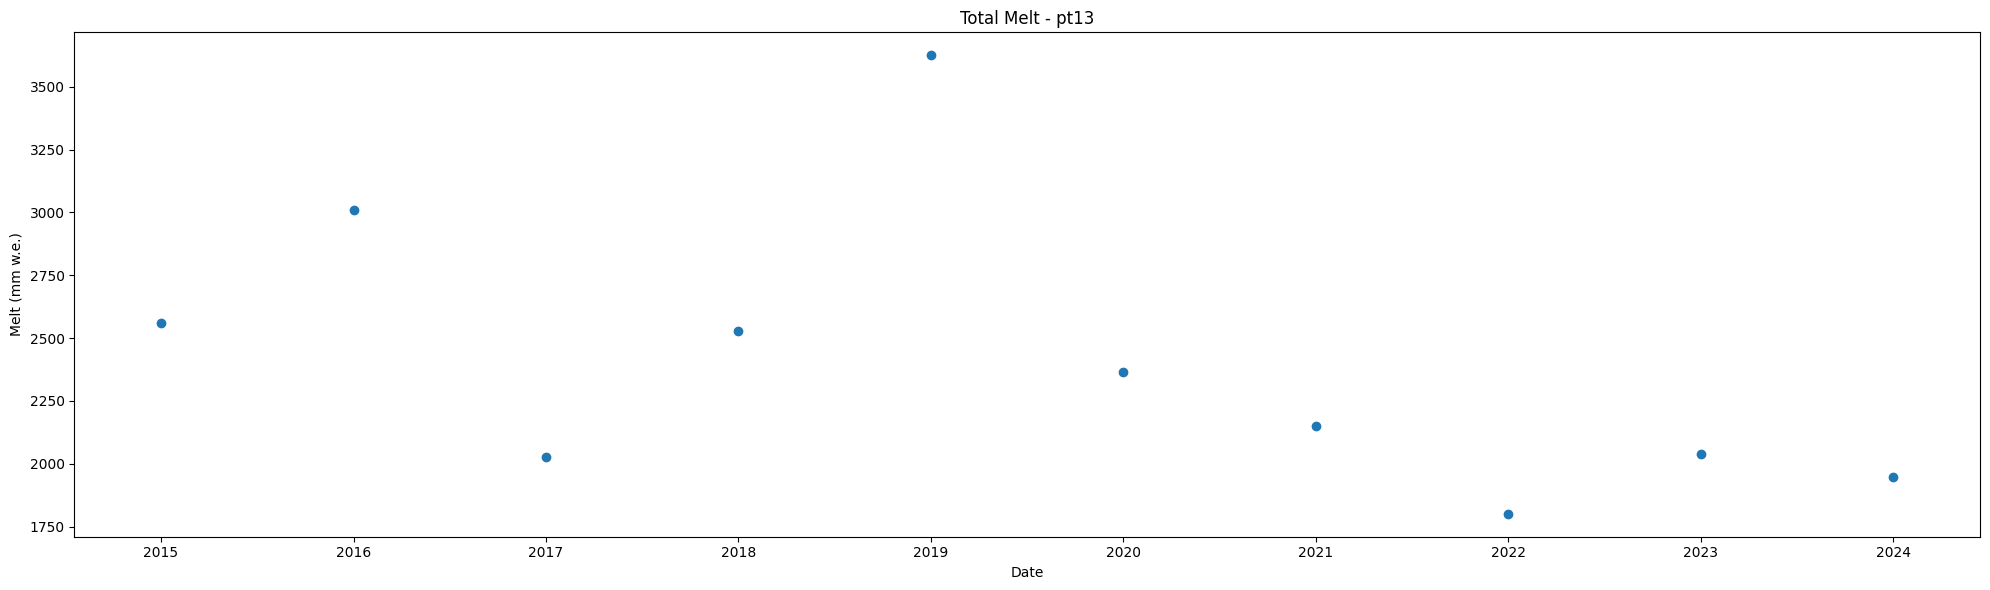

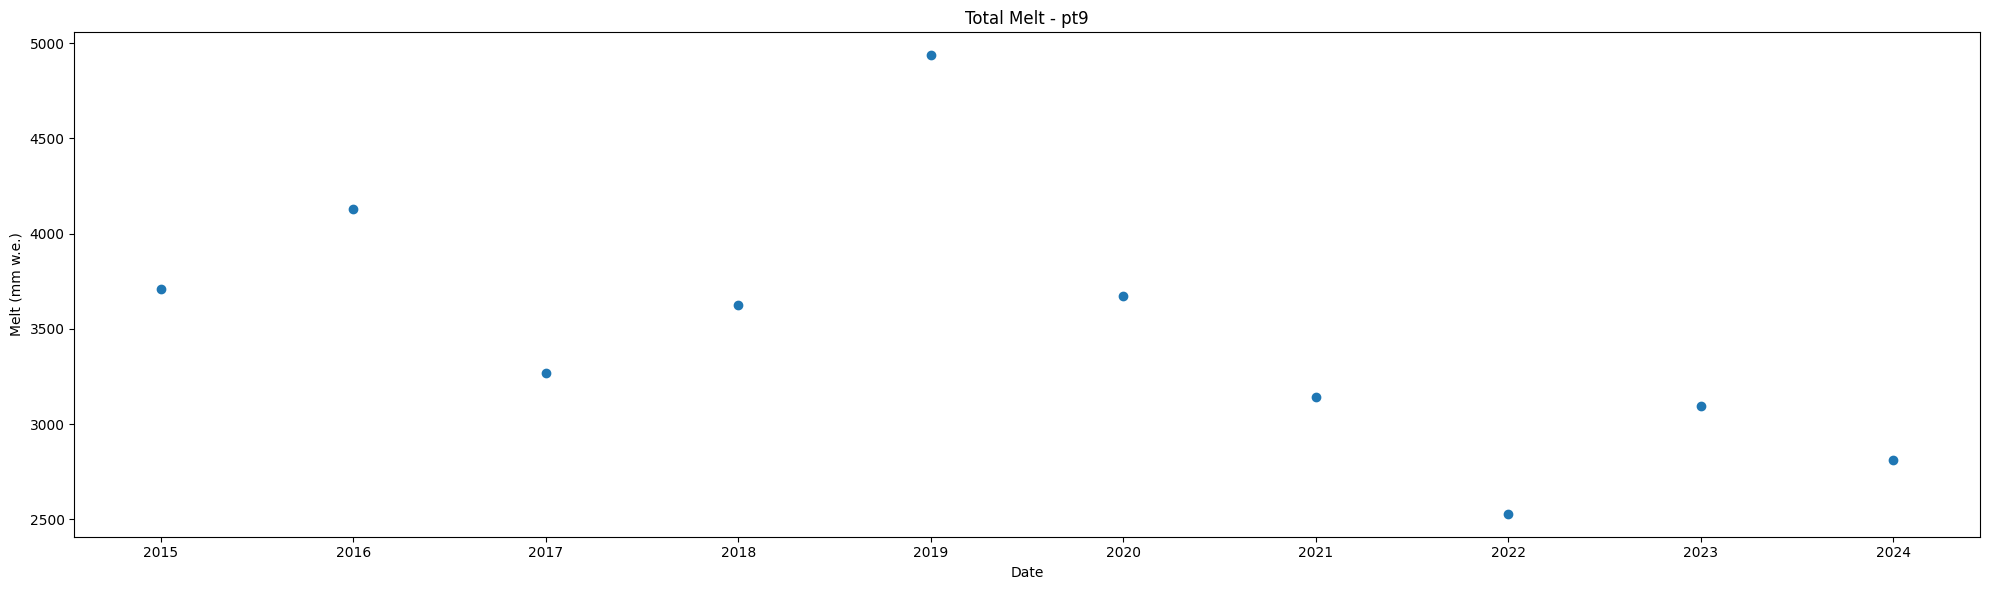

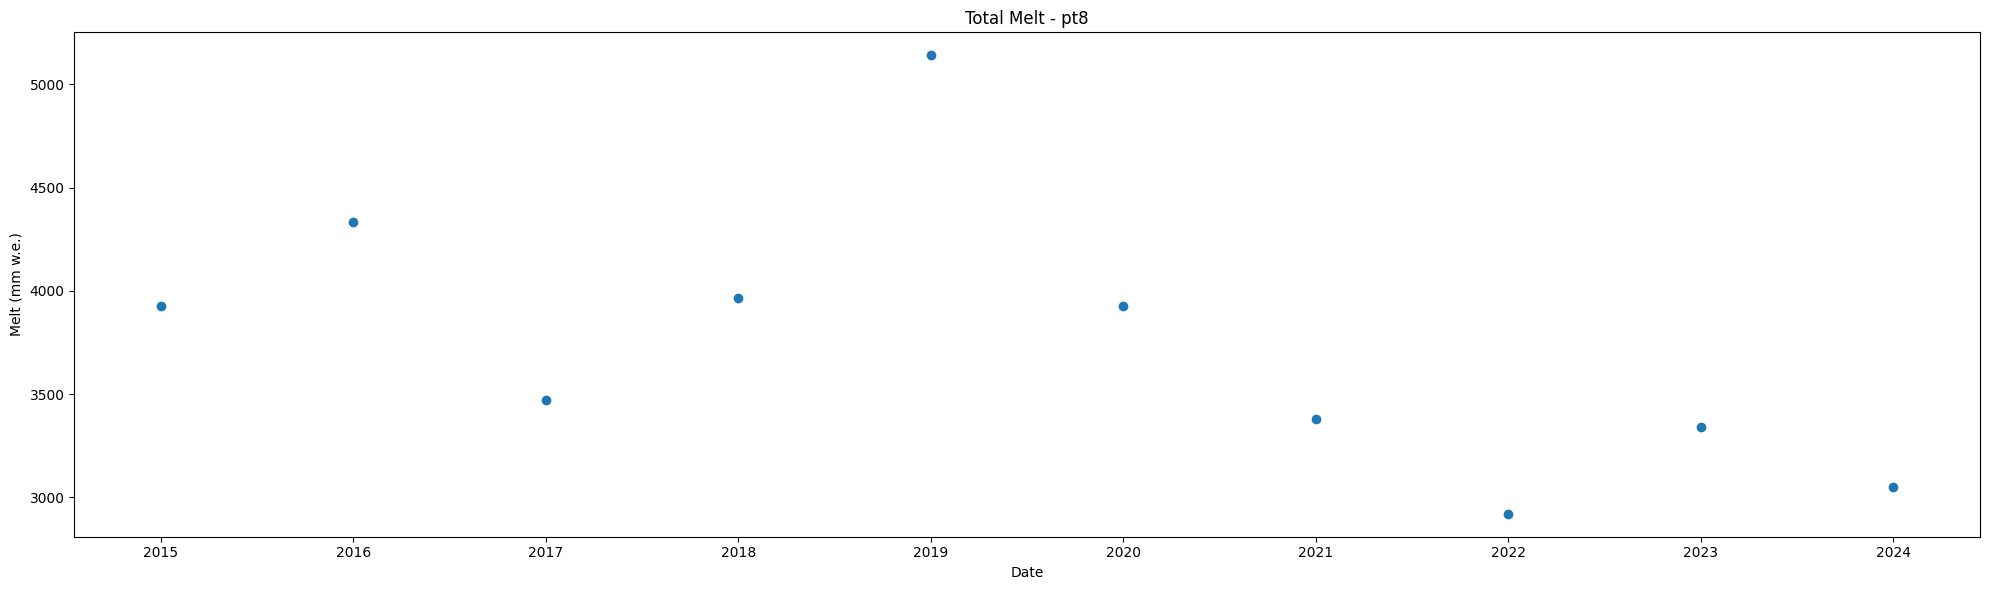

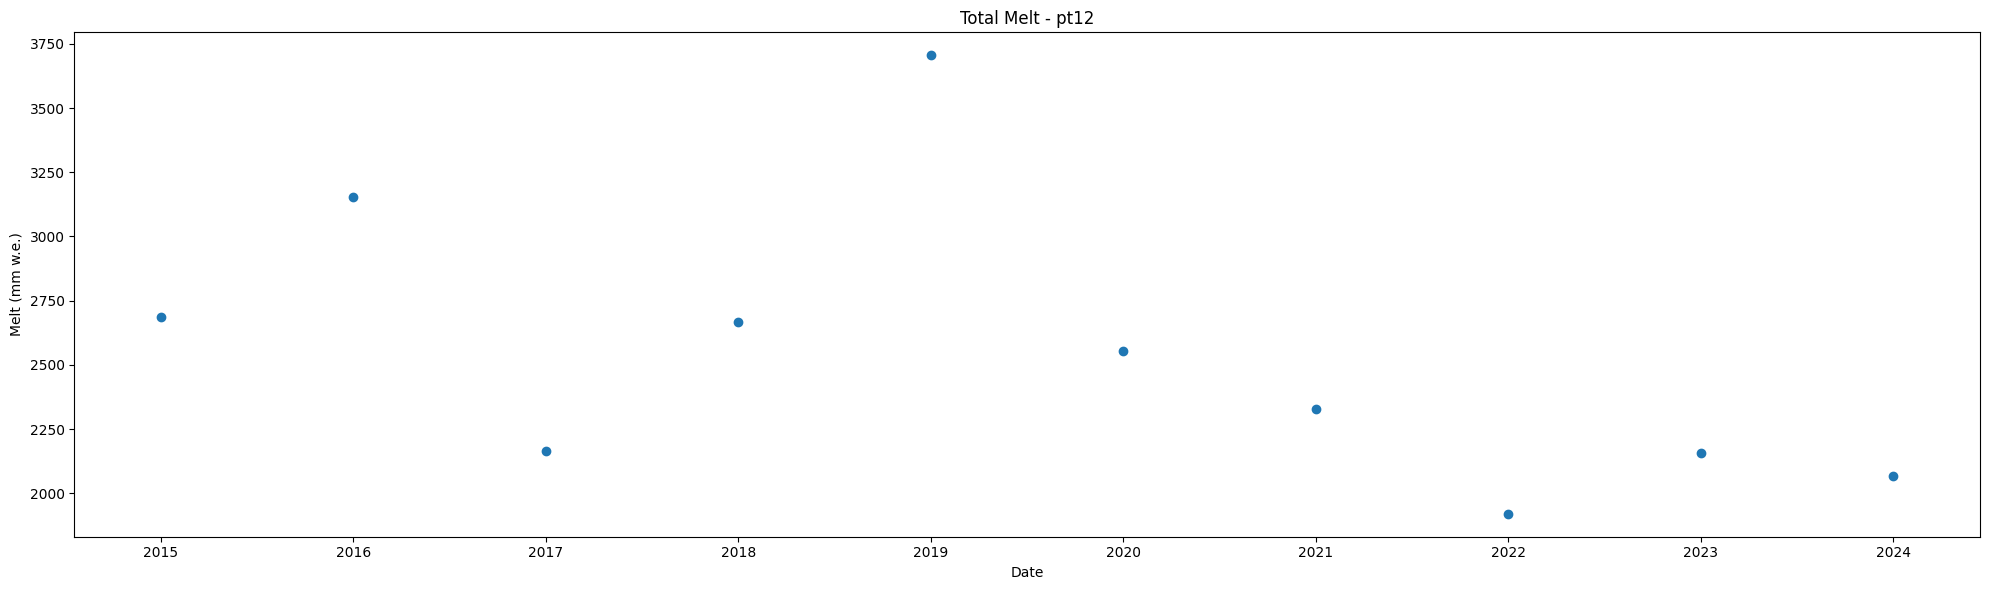

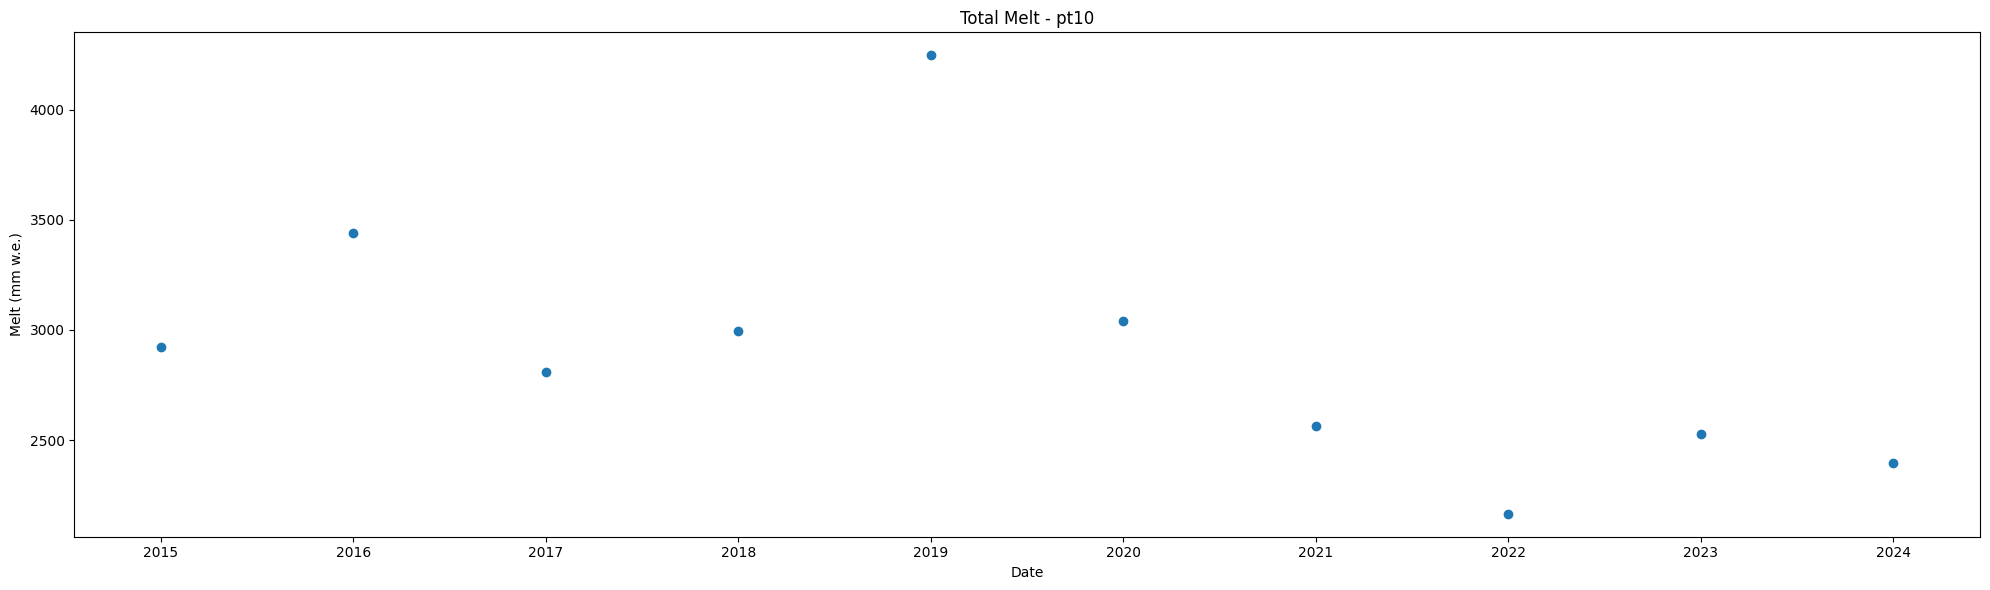

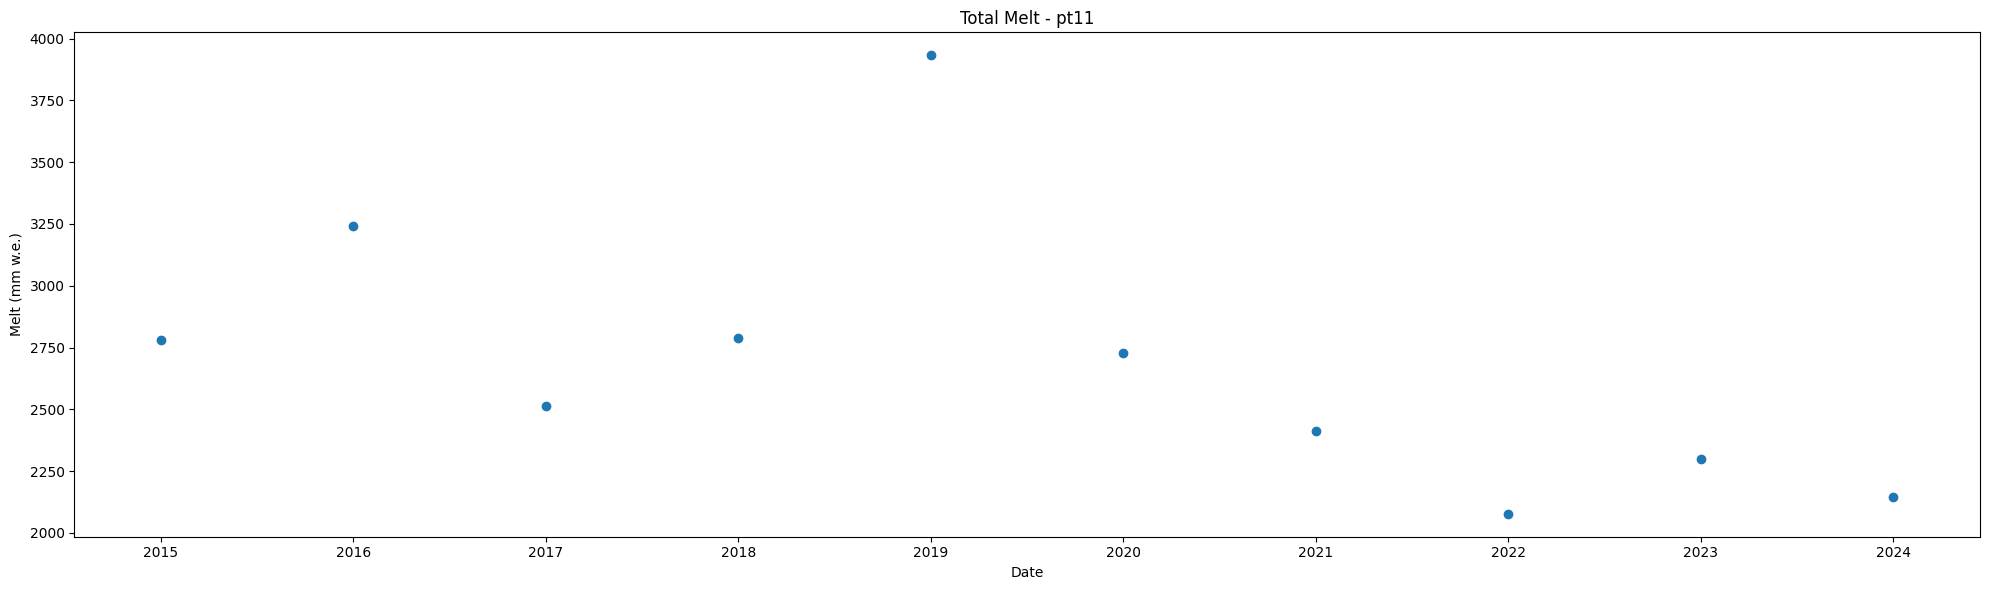

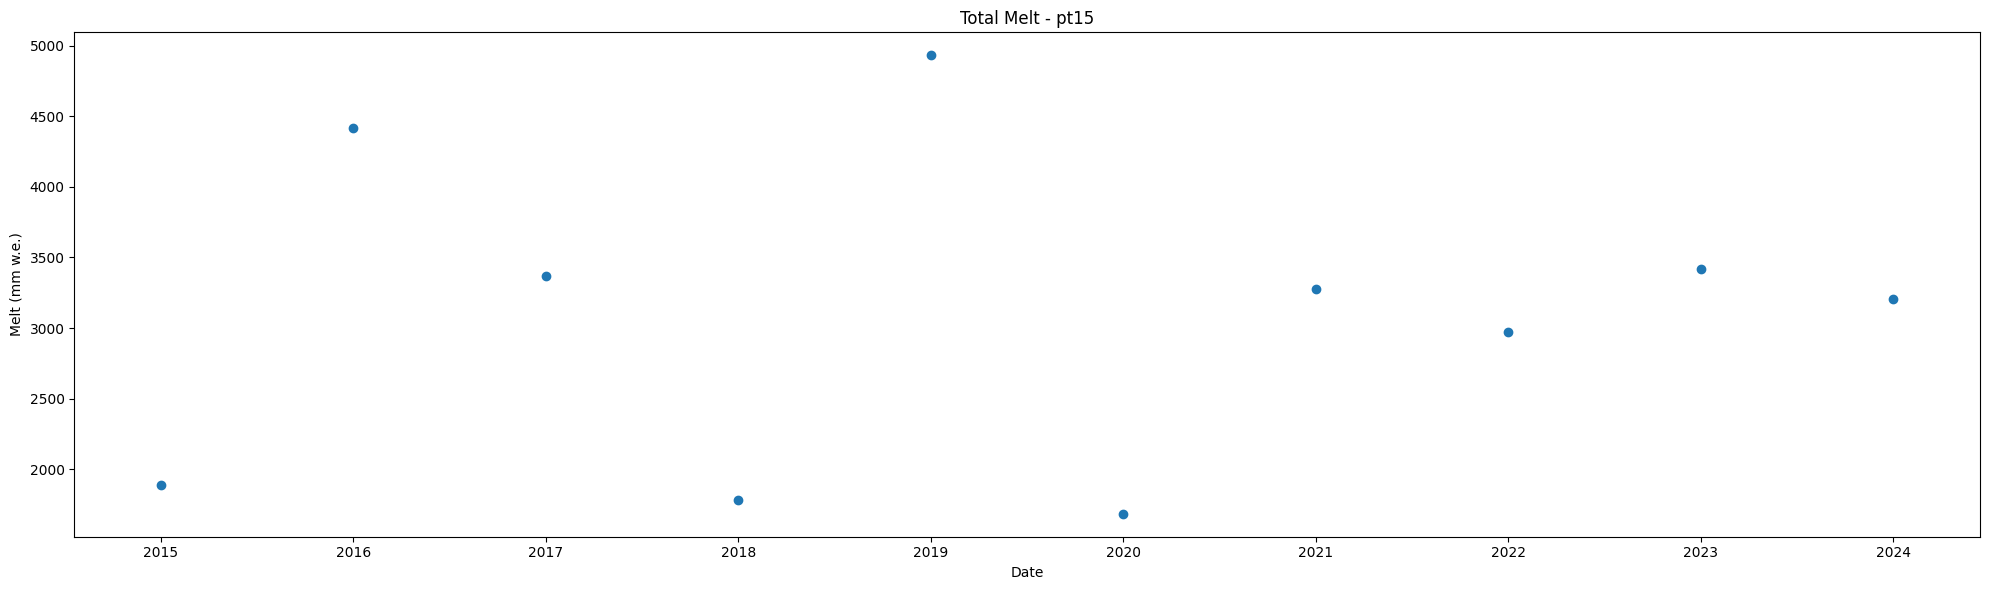

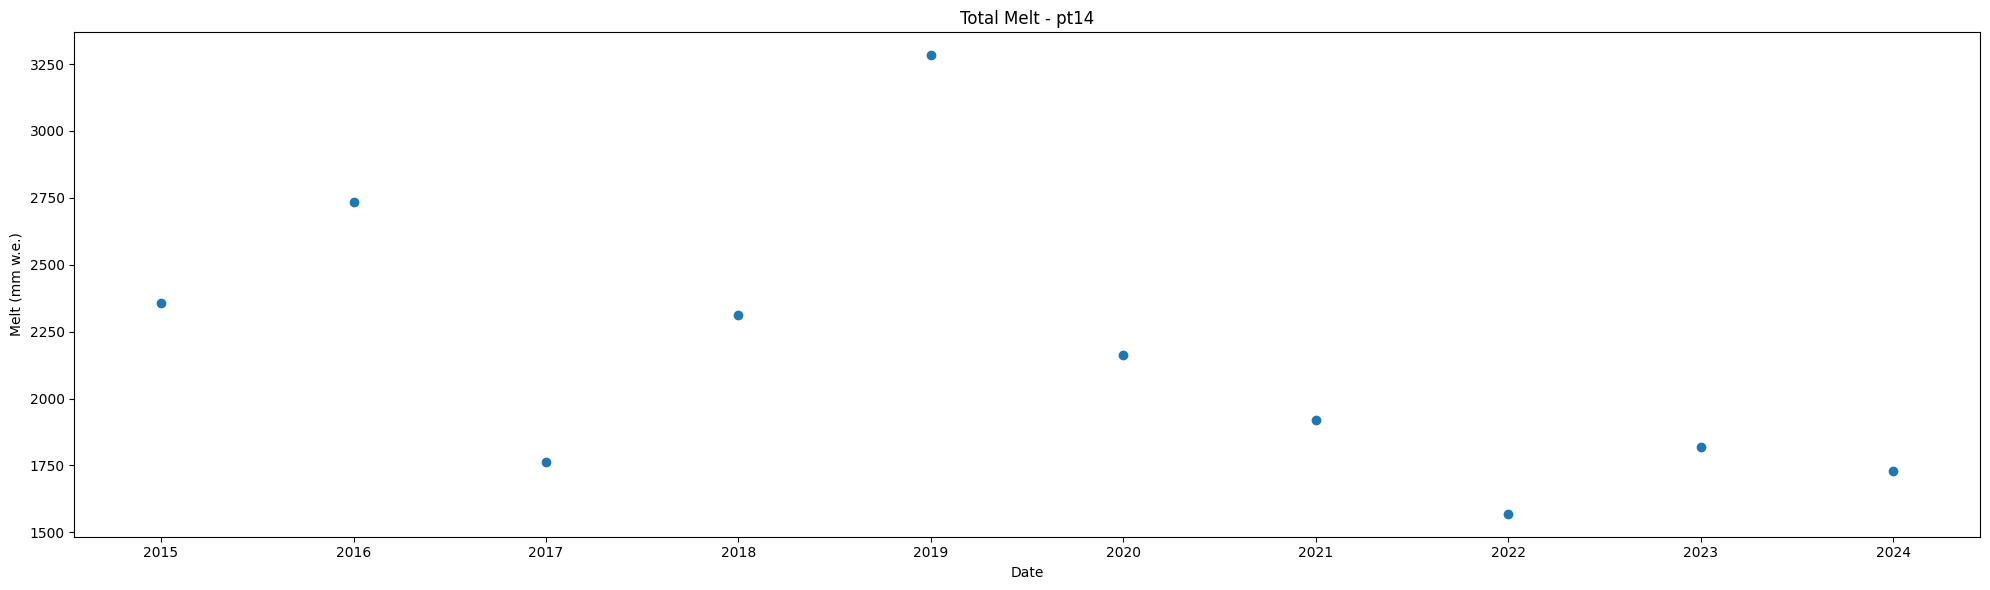

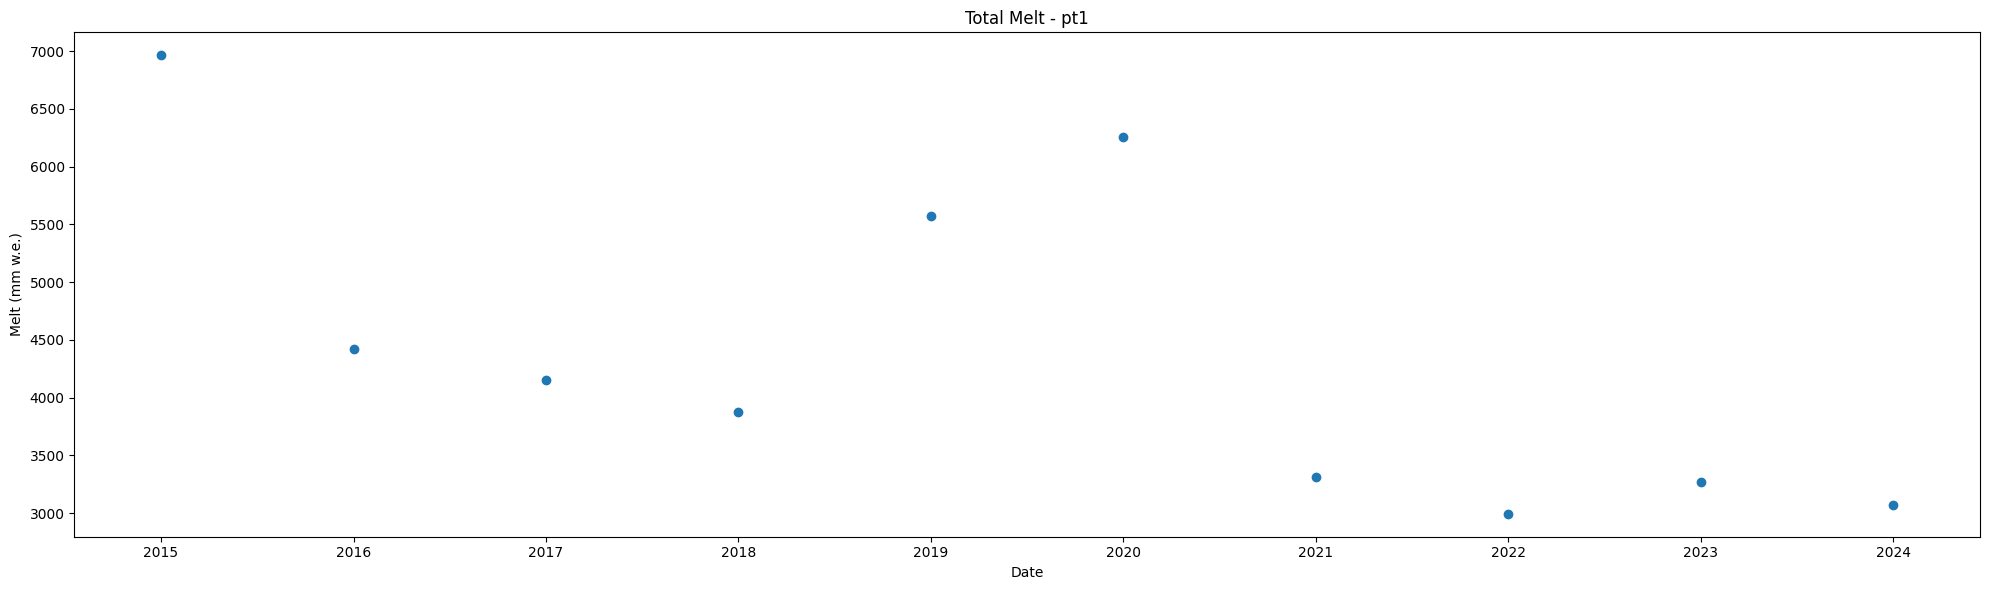

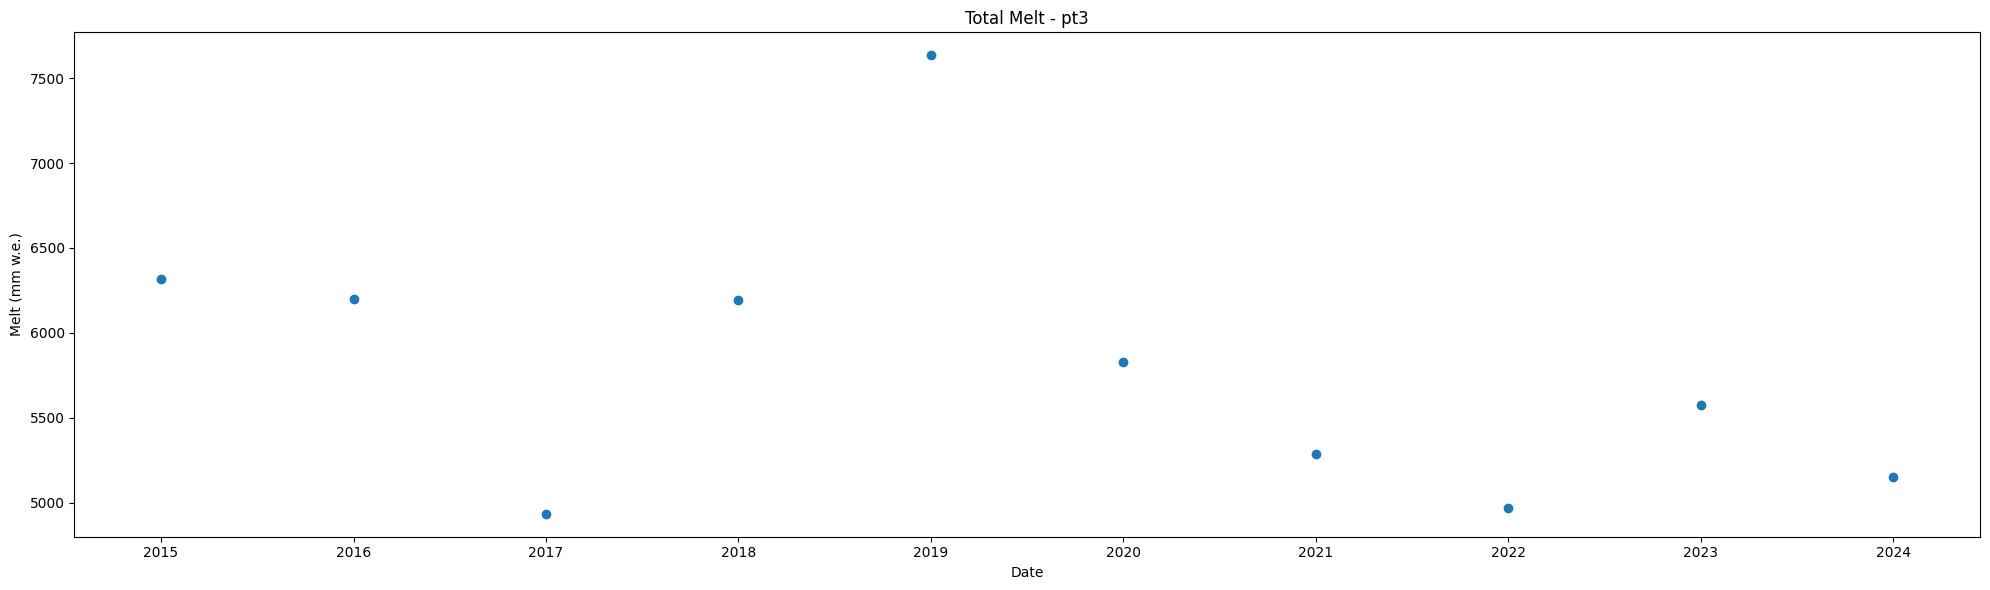

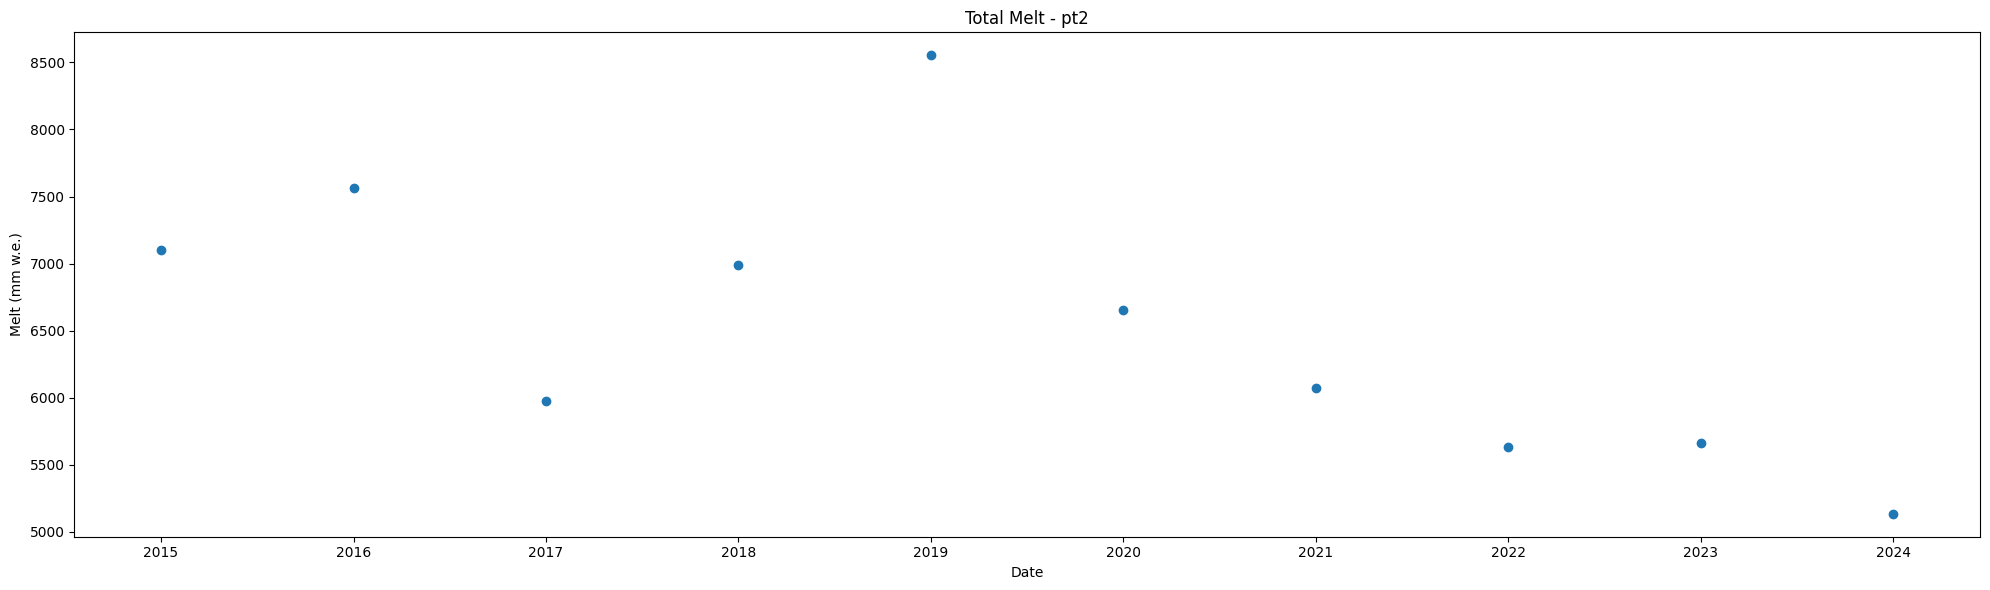

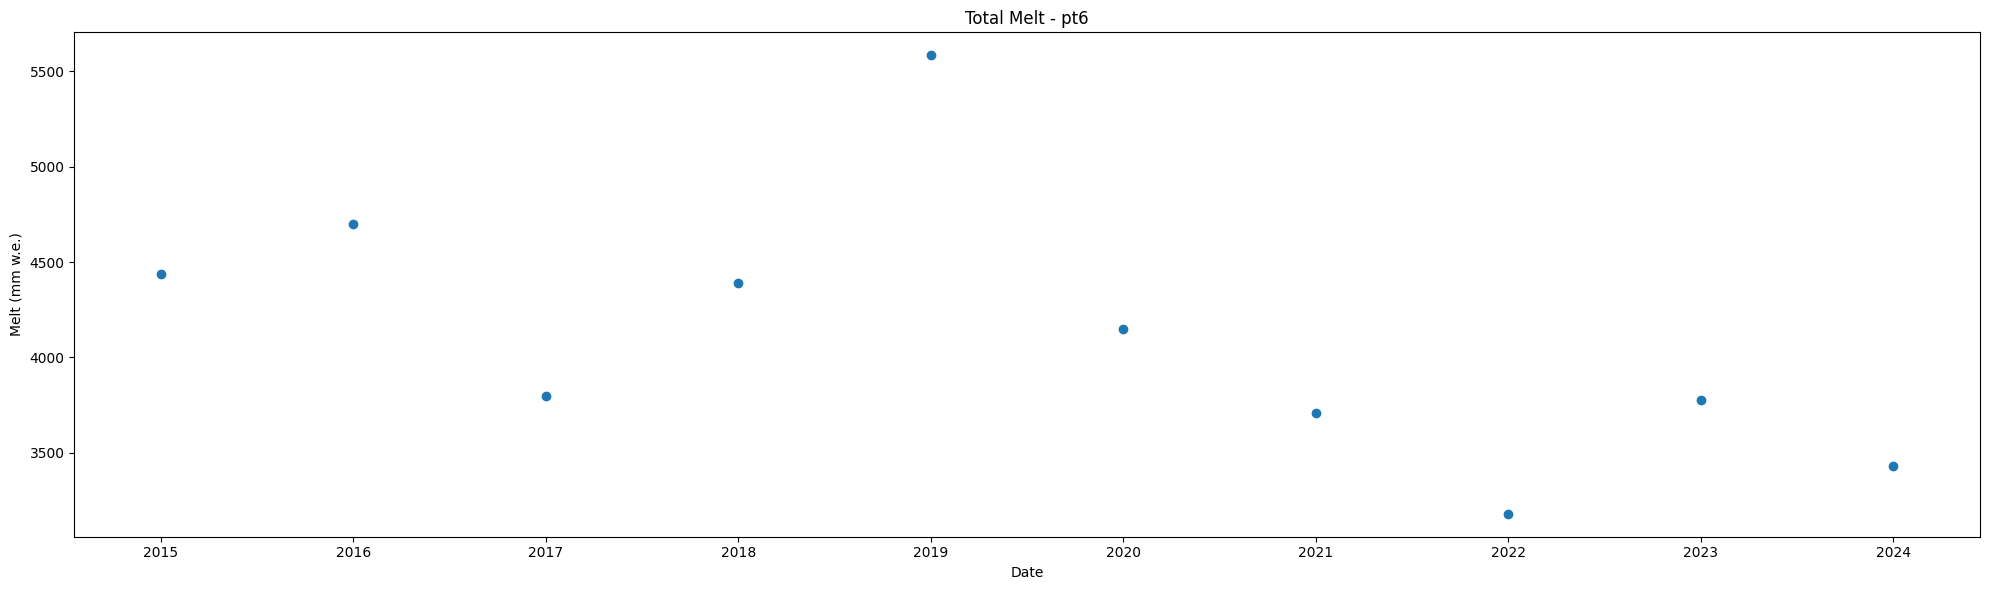

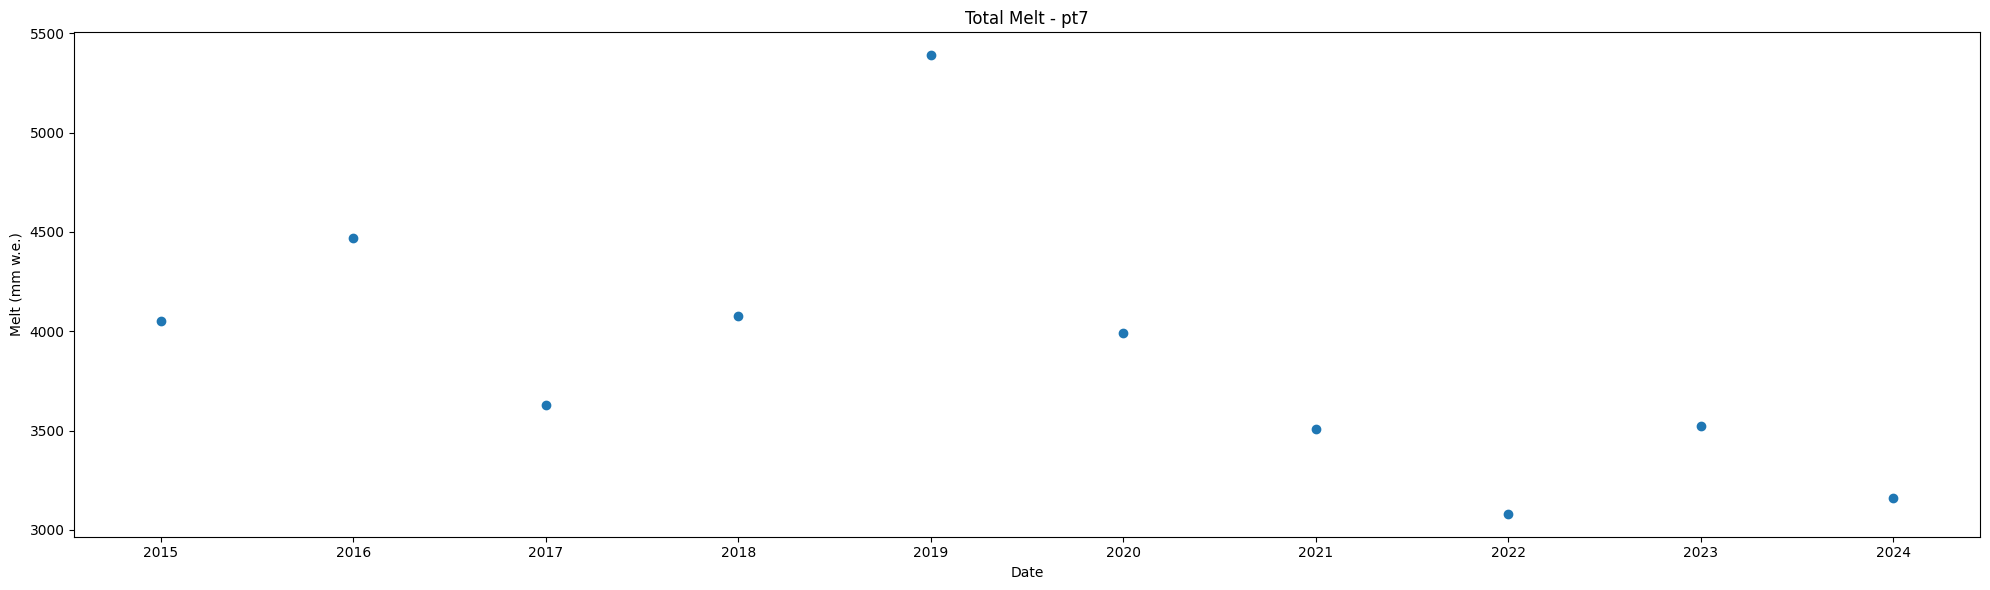

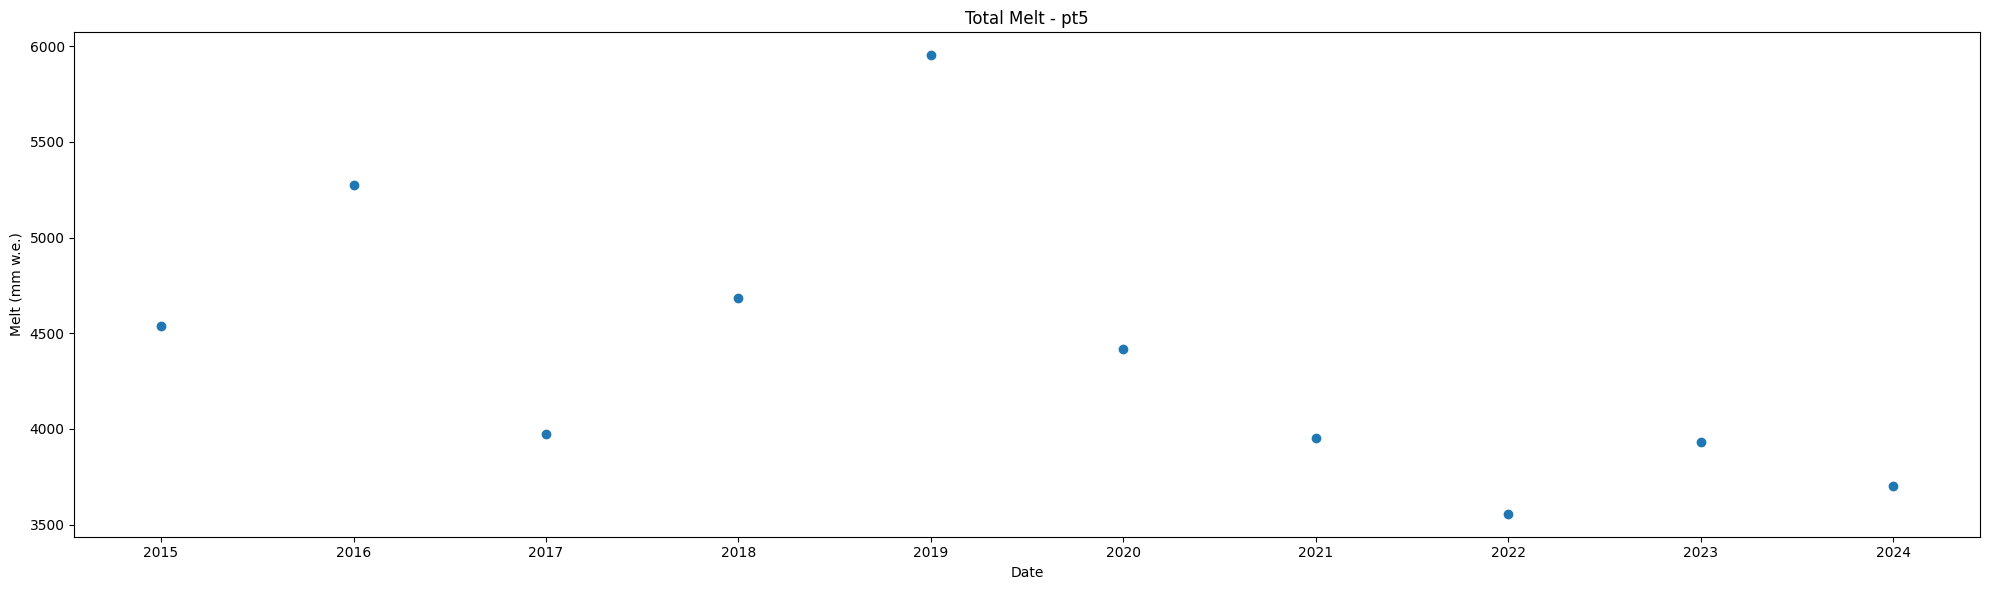

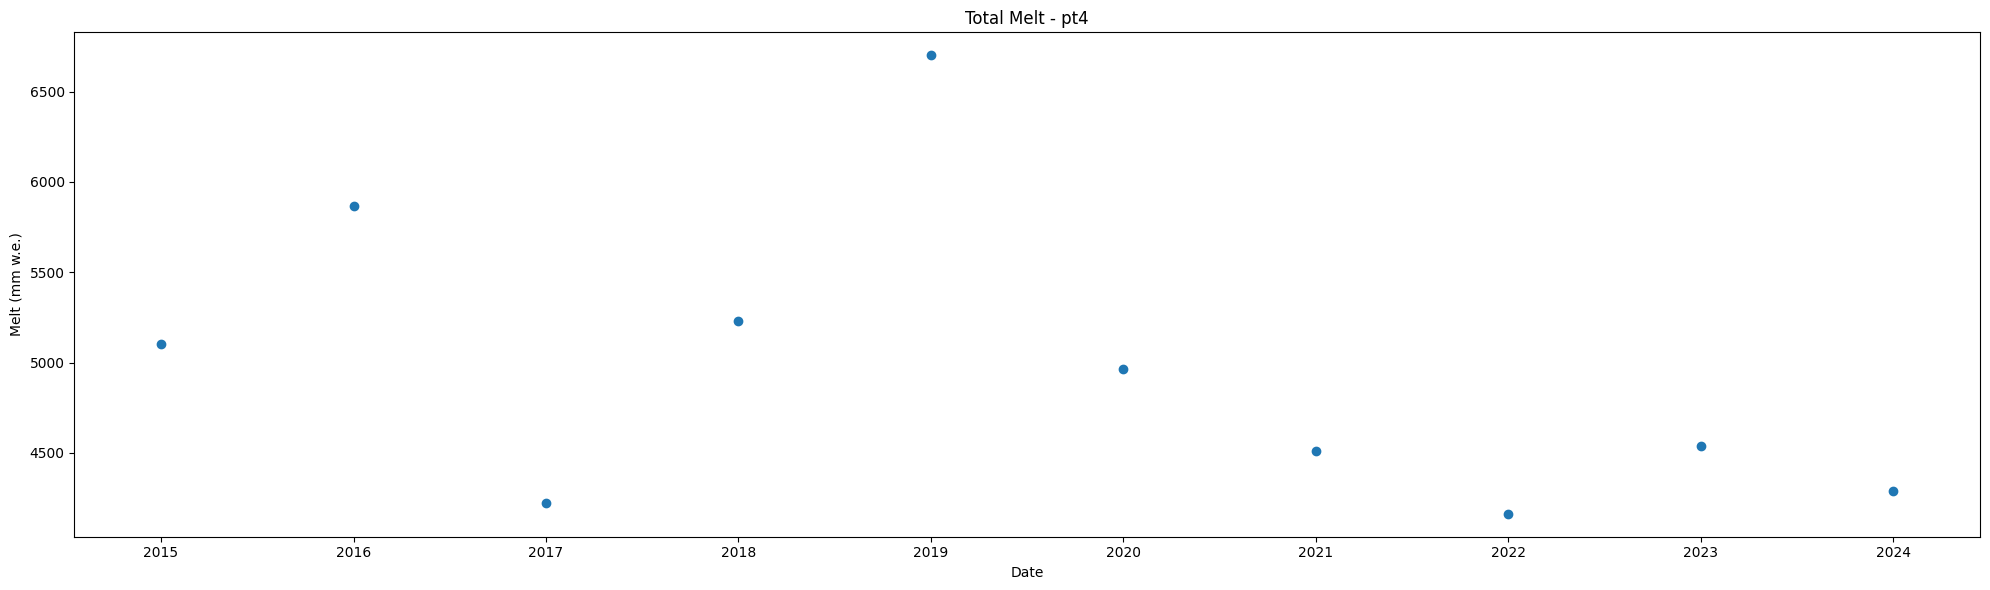

In [27]:
#plot total melt at each point
for pt_name, pt_df in total_melt.items():
    plt.figure(figsize=(20, 6))
    plt.title(f'Total Melt - {pt_name}')
    plt.xlabel('Date')
    plt.ylabel('Melt (mm w.e.)')
    plt.scatter(pt_df['year'], pt_df['total_melt'])
    plt.xticks(pt_df['year'])
    
    plt.tight_layout()
    plt.show()

In [28]:
for pt_name, df in total_melt.items():
    df.to_csv(f'{out_path}total_melt_{pt_name}.csv', index=False)